# Setup

## Instructions
1. Work on a copy of this notebook: _File_ > _Save a copy in Drive_ (you will need a Google account).
2. (Optional) If you would like to do the deep learning component of this tutorial, turn on the GPU with Edit->Notebook settings->Hardware accelerator->GPU


In [ ]:
!pip install -U pysr

Julia and Julia dependencies are installed at first import:

In [1]:
import pysr

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


Now, let's import everything else as well as the PySRRegressor:


In [2]:
import sympy
import numpy as np
from matplotlib import pyplot as plt
from pysr import PySRRegressor
from sklearn.model_selection import train_test_split

# Simple PySR example:


First, let's learn a simple function

$$2.5382 \cos(x3) + x0^2 - 2$$

In [3]:
import torch
event = 101
activations = torch.load(
    f"activations/activations_event{event:09d}.pt", map_location=torch.device("cpu")
)

keys = list(activations)
layer_1_name = keys[0]
layer_4_name = keys[3]

# Transpose the activation to get the neuron distributions
neuron_activations = {
    layer_name: layer_activations.T
    for layer_name, layer_activations in activations.items()
}

# Get neuron 935 from layer 4
neuron_935 = neuron_activations[layer_4_name][935]
print(neuron_935)
print(neuron_935.shape)
# Normalize the neuron distribution 
neuron_935 = neuron_935 / neuron_935.sum()
# Divide by max to get the neuron distribution
neuron_935 = neuron_935 / neuron_935.max()

tensor([ 1.4221,  1.0920,  0.8210,  ...,  8.9779,  7.9711, 10.3340])
torch.Size([14183])


In [36]:
# Get the input data
from pathlib import Path
import pandas as pd


# Load Data Function
def load_csv_data(file_name="input_data_event000000101.csv", directory="csv"):
    csv_dir = Path(directory)
    csv_file = csv_dir / file_name
    df = pd.read_csv(csv_file)
    return df

df = load_csv_data(directory="./csv")
df.columns = ["r", "phi", "z"]
print(df)
feature_scale = [1000, 3.14, 1000]

# Plot distribution of input data for each feature
feature_names = df.columns

# Scale the data
for feature_name in feature_names:
    df[feature_name] = (
        df[feature_name] * feature_scale[feature_names.get_loc(feature_name)]
    )

# del df['0']
# del df['1']
# del df['2']
print(df)

# Add coordinates transformation
def add_coordinate_transformations(df):
    df["x"] = df["r"] * np.cos(df["phi"])
    df["y"] = df["r"] * np.sin(df["phi"])
    df["theta"] = np.arctan2(df["r"], df["z"])
    # df["theta2"] = 2*np.arctan(df["r"] / (np.sqrt(df["r"] ** 2 + df["z"] ** 2) + df["z"]))
    df["rho"] = np.sqrt(df["r"] ** 2 + df["z"] ** 2)
    df["eta"] = -np.log(np.tan(df["theta"] / 2))
    # df["eta2"] = -np.log(df["r"] / (df["rho"] + df["z"]))
    # df["eta3"] = -np.log(np.sin(df["theta"] / 2) / np.cos(df["theta"] / 2))
    return df

df = add_coordinate_transformations(df)
print(df)


# Convert the input data to a tensor
input_data = torch.tensor(df.values)
print(input_data)

              r       phi        z
0      0.046080 -0.960068 -0.26300
1      0.040858 -0.917418 -0.26300
2      0.036669 -0.872193 -0.26300
3      0.040137 -0.871853 -0.28600
4      0.050385 -0.960222 -0.28600
...         ...       ...      ...
14178  0.669298 -0.398698  2.83925
14179  0.811482 -0.292720  2.85425
14180  0.715819 -0.280489  2.83925
14181  0.652247 -0.144629  2.83925
14182  0.800914 -0.152819  2.83925

[14183 rows x 3 columns]
                r       phi        z
0       46.079885 -3.014614  -263.00
1       40.857904 -2.880693  -263.00
2       36.669284 -2.738686  -263.00
3       40.136770 -2.737618  -286.00
4       50.384663 -3.015098  -286.00
...           ...       ...      ...
14178  669.297900 -1.251913  2839.25
14179  811.481800 -0.919142  2854.25
14180  715.818500 -0.880737  2839.25
14181  652.247200 -0.454135  2839.25
14182  800.914000 -0.479850  2839.25

[14183 rows x 3 columns]
                r       phi        z           x           y     theta  \
0       46

In [5]:
# Assign the input data to the label (neuron 935)
label = neuron_935

# Split the data into training and testing
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(input_data, label, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Randomly remove 50% of the data (and labels)
import random

# Set the seed
random.seed(42)

# Remove 90% of the data
indices = random.sample(range(X_train.shape[0]), int(X_train.shape[0] * 0.1))
X_train = X_train[indices]
y_train = y_train[indices]

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


# Create the dataset
dataset = {
    "train_input": X_train,
    "train_label": y_train,
    "test_input": X_test,
    "test_label": y_test,
}

torch.Size([11346, 8]) torch.Size([2837, 8]) torch.Size([11346]) torch.Size([2837])
torch.Size([1134, 8]) torch.Size([2837, 8]) torch.Size([1134]) torch.Size([2837])


In [6]:
X = dataset["train_input"].numpy()
y = dataset["train_label"].numpy()

By default, we will set up 30 populations of expressions (which evolve independently except for migrations), use 4 threads, and use `"best"` for our model selection strategy:

In [7]:
default_pysr_params = dict(
    populations=30,
    model_selection="best",
)

PySR can run for arbitrarily long, and continue to find more and more accurate expressions. You can set the total number of cycles of evolution with `niterations`, although there are also a [few more ways](https://github.com/MilesCranmer/PySR/pull/134) to stop execution.

**This first execution will take a bit longer to startup, as the library is JIT-compiled. The next execution will be much faster.**

In [48]:
# Learn equations
# model = PySRRegressor(
#     niterations=30,
#     binary_operators=["+", "*", "atan2(x1, x2) = 2*atan(x1/(sqrt(1+x2^2)+x2))"],
#     unary_operators=["cos", "exp", "sin", "log", "sqrt"],
#     extra_sympy_mappings={"atan2": lambda x1, x2: 2 * sympy.atan(x1 / (sympy.sqrt(1 + x2 ** 2) + x2))},
#     maxsize=40,
#     **default_pysr_params,
# )

model = PySRRegressor(
    niterations=30,
    binary_operators=["+", "*"],
    unary_operators=["cos", "exp", "sin", "log", "sqrt"],
    maxsize=40,
    complexity_of_constants=0.1,
    nested_constraints={"sin": {"cos": 0, "sin": 0}, "cos": {"cos": 0, "sin": 0}, "exp": {"exp": 0}, "log": {"log": 0}, "sqrt": {"sqrt": 0}},
    **default_pysr_params,
)

model.fit(X, y)

/home/couthures/anaconda3/envs/ML/lib/python3.11/site-packages/pysr/sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 3.700e+04
Head worker occupation: 18.1%
Progress: 83 / 900 total iterations (9.222%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           8.180e-02  1.594e+01  y = 0.17589 * 1.53
2           6.446e-02  2.382e-01  y = sin(x₅)
3           4.405e-02  3.809e-01  y = sin(x₅) * 0.70024
4           3.679e-02  1.800e-01  y = 0.70024 * sin(x₅ + -0.17319)
5           3.608e-02  1.952e-02  y = (sin(-0.17573 + x₅) * 0.65173) + 0.053803
6           3.576e-02  8.932e-03  y = (sin(x₅ + -0.17573) * sin(0.65173)) + 0.053803
7           2.476e-02  3.676e-01  y = 0.52557 * (cos(log(x₀) * -0.78862) + cos(-0.043373))
9           1.528e-02  2.412e-01  y = sin(x₅) * (exp(sin(log(x₆) + 0.52133)) * 0.51363)
10          1.031e-02  3.942e-01  y = sqrt(-0.1904 + exp(sin(log(x₆)))) * sin(x₅ + -0.0764)
11          9.672e-03  6.350e-02  y = sqrt(exp(sin(log(x₆))) + -0.

PySRRegressor.equations_ = [
	    pick         score                                           equation  \
	0         0.000000e+00                             0.4235014 * 0.63806224   
	1         2.381744e-01                                            sin(x5)   
	2         3.808920e-01                               sin(x5) * 0.69962454   
	3         2.424321e-01                sqrt(x0) * (0.13453886 * 0.1653307)   
	4         4.775556e-02  (sqrt(x0) * (0.13453886 * 0.1653307)) + -0.037...   
	5         8.851341e-01                  (sin(x5) * 0.03505834) * sqrt(x6)   
	6         1.470839e-07              (sin(x5) * cos(1.5357323)) * sqrt(x6)   
	7         3.995356e-02  ((sin(x5) * cos(1.535625)) * sqrt(x6)) + -0.01...   
	8         1.047392e+00  ((sin(x5 * 0.95774955) * cos(1.524796)) * sqrt...   
	9         3.096337e-03  ((sin(x5 * 0.95774955) * cos(1.524796)) * sqrt...   
	10        1.393368e-01  (sqrt(x6 + 1.041987) * ((sin(x5 * 0.9558515) *...   
	11        1.928173e-01  0.12688333 * (exp(cos(log(0.7597586 * x0)) + c...   
	12        8.434731e-02  (exp(cos(x7 * -0.568424) + cos(log(x0 * 0.7776...   
	13        1.552357e-03  (exp(cos(x7 * -0.568424) + cos(log(x0 * 0.7776...   
	14  >>>>  2.239989e-01  ((exp(cos(0.5517442 * x7) + cos(log(x0 + x0) *...   
	15        5.207052e-02  ((exp(cos(0.5517442 * (x7 + 0.1009167)) + cos(...   
	16        2.254797e-02  ((exp(cos(0.5517442 * (x7 + 0.1009167)) + cos(...   
	17        1.483574e-02  ((exp(cos(0.5517442 * (x7 + (0.1009167 * 1.454...   
	18        8.266497e-04  ((exp(cos((0.1009167 + x7) * 0.5517442) + cos(...   
	19        5.921460e-04  ((exp(cos((0.1009167 + x7) * 0.5517442) + cos(...   
	20        6.217574e-03  ((exp(cos((0.1009167 + x7) * 0.5517442) + cos(...   
	21        1.289510e-01  (exp(cos(log(x0 + x0) * -0.85104245) + cos((0....   
	22        1.395104e-03  (0.1470985 * ((sin(-0.53041375 + (x7 * log(0.7...   
	
	        loss  complexity  
	0   0.081801           1  
	1   0.064464           2  
	2   0.044045           3  
	3   0.034563           4  
	4   0.032951           5  
	5   0.013598           6  
	6   0.013598           7  
	7   0.013065           8  
	8   0.004584           9  
	9   0.004570          10  
	10  0.003975          11  
	11  0.002703          13  
	12  0.002485          14  
	13  0.002481          15  
	14  0.001983          16  
	15  0.001787          18  
	16  0.001747          19  
	17  0.001721          20  
	18  0.001720          21  
	19  0.001719          22  
	20  0.001708          23  
	21  0.001502          24  
	22  0.001485          32  
]

We can print the model, which will print out all the discovered expressions:

In [38]:
model

PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                    sin(0.27361223)   
	1         0.238174                                            sin(x5)   
	2         0.791319                             sin(x0 * 0.0015304514)   
	3         0.129740                        sin(sin(x0 * 0.0015304514))   
	4         0.032606    sin(log(sqrt(0.78252536 + (0.005055775 * x0))))   
	5         0.011259  sin(sin(cos(-1.8672676)) + (0.04088088 * sqrt(...   
	6         0.000723  sin(sin(sin(cos(-1.8672676))) + (0.04088088 * ...   
	7         0.914129  sin(log(sqrt(0.78252536 + ((sqrt(x5) * 0.00505...   
	8         1.121045  sin(log(sqrt(((sin(x5 * 0.8685715) * 0.0105258...   
	9         0.048269  sin(log(sqrt((x0 * (sin(x5 * 0.8685715) * 0.01...   
	10        0.004591  sin(log(sqrt(cos(-0.5783208) + ((1.413636 + x0...   
	11        0.019210  sin(log(sqrt(cos(-0.5783208) + ((x0 + x1) * (0...   
	12        0.004094  sin(log(sqrt(cos(-0.5783208) + (((1.2509311 + ...   
	13        0.025657  sin(2.2430716 + sin(sqrt(sqrt(sqrt((2.269111 *...   
	14        0.003770  sin(sin(sqrt(sqrt(sqrt(((x0 * 2.269111) * ((sq...   
	15        0.043611  sin(2.2430716 + sin(sqrt(sqrt(sqrt((2.269111 *...   
	16        0.010873  sin(2.2430716 + sin(sqrt(sqrt(sqrt((2.269111 *...   
	17        0.007880  sin(2.2430716 + sin(sqrt(sqrt(sqrt((x0 * 2.269...   
	18        0.082020  sin(sin(sin(sqrt(0.9601448 + (sqrt(sqrt((x0 + ...   
	19        0.008730  sin(2.4993398 + sin(sin(sqrt(0.9601448 + (sqrt...   
	20        0.051313  sin(2.4993398 + sin(sin(sqrt(1.0125823 + (sqrt...   
	21  >>>>  0.087676  sin(2.4986367 + sin(sin(sqrt(0.96003306 + (sqr...   
	22        0.002759  sin(2.4986367 + sin(sin(sqrt(0.96003306 + (sqr...   
	23        0.013930  sin(2.4986367 + sin(sin(sqrt(0.96003306 + (sqr...   
	24        0.012723  sin(2.4993398 + sin(sin(sqrt(0.9601448 + (sqrt...   
	25        0.035620  sin(2.4993398 + sin(sin(sqrt(0.9601448 + (sqrt...   
	26        0.000587  sin(2.4993398 + sin(sin(sqrt(0.9601448 + (sqrt...   
	27        0.001531  sin(2.4993398 + sin(sin(sqrt(0.9601448 + (sqrt...   
	28        0.009101  sin(2.4993398 + sin(sin(sqrt(0.9601448 + (sqrt...   
	29        0.026445  sin(2.4993398 + sin(sin(sqrt(0.9601448 + (sqrt...   
	
	        loss  complexity  
	0   0.081801           1  
	1   0.064464           2  
	2   0.029218           3  
	3   0.025663           4  
	4   0.024043           6  
	5   0.023774           7  
	6   0.023757           8  
	7   0.009523           9  
	8   0.003104          10  
	9   0.002958          11  
	10  0.002944          12  
	11  0.002888          13  
	12  0.002876          14  
	13  0.002732          16  
	14  0.002722          17  
	15  0.002495          19  
	16  0.002468          20  
	17  0.002410          23  
	18  0.002046          25  
	19  0.002028          26  
	20  0.001738          29  
	21  0.001593          30  
	22  0.001584          32  
	23  0.001562          33  
	24  0.001542          34  
	25  0.001488          35  
	26  0.001487          36  
	27  0.001485          37  
	28  0.001472          38  
	29  0.001433          39  
]

We can also view the SymPy format of the best expression:

In [49]:
model.sympy()

-0.0388310319239848*x7 + 0.13119934*exp(cos(0.5517442*x7) + cos(0.85104245*log(2*x0))) - 0.0438885893618758

We can also view the SymPy of any other expression in the list, using the index of it in `model.equations_`.

In [50]:
model.sympy(2)

sin(x5)*0.69962454

## Output

`model.equations_` is a Pandas DataFrame. We can export the results in various ways:

In [43]:
model.latex()

'\\left(\\cos{\\left(\\sin{\\left(\\log{\\left(\\sqrt{x_{6}} \\right)} \\right)} + 1.35 \\right)} + 1.11\\right) \\sin{\\left(\\log{\\left(e^{\\sin{\\left(\\sin{\\left(x_{5} - 0.0735 \\right)} \\right)}} \\right)} + 0.114 \\right)} - 0.261'

These is also `model.sympy(), model.jax(), model.pytorch()`. All of these can take an index as input, to get the result for an arbitrary equation in the list.

We can also use `model.predict` for arbitrary equations, with the default equation being the one chosen by `model_selection`:

In [44]:
ypredict = model.predict(X)
ypredict_simpler = model.predict(X, 2)

print("Default selection MSE:", np.power(ypredict - y, 2).mean())
print("Manual selection MSE for index 2:", np.power(ypredict_simpler - y, 2).mean())

Default selection MSE: 0.0010813370665797703
Manual selection MSE for index 2: 0.032839211211906784


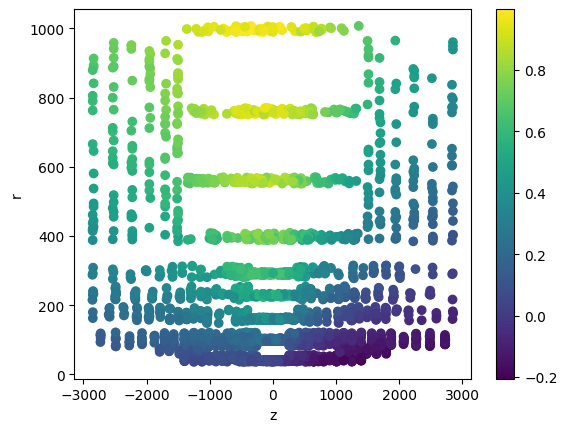

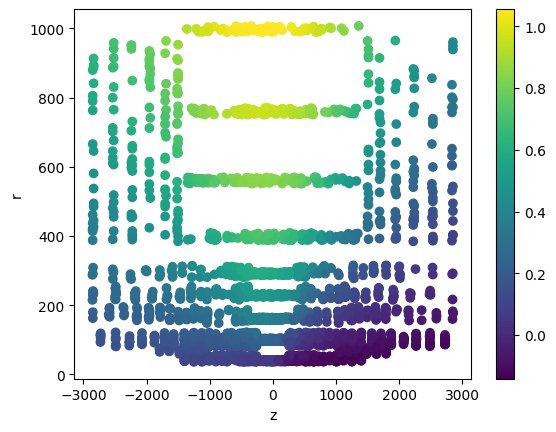

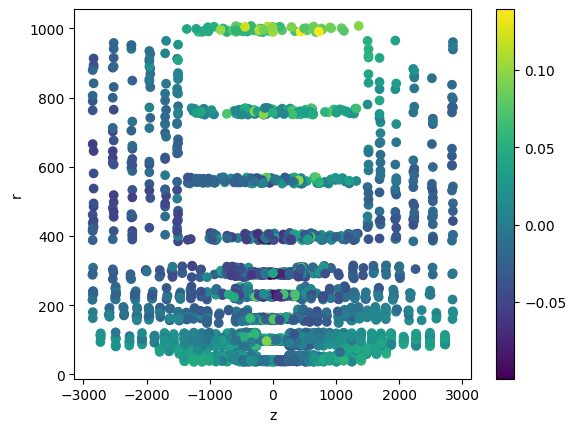

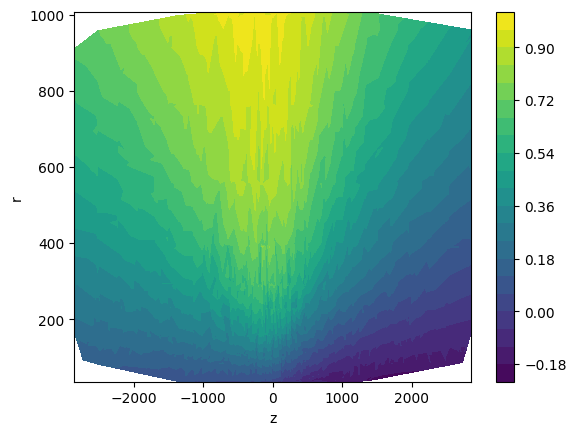

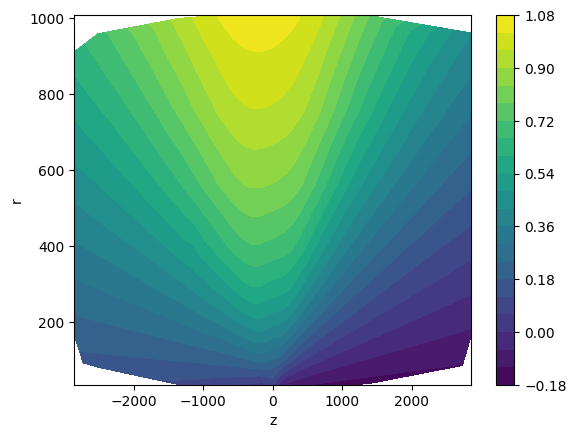

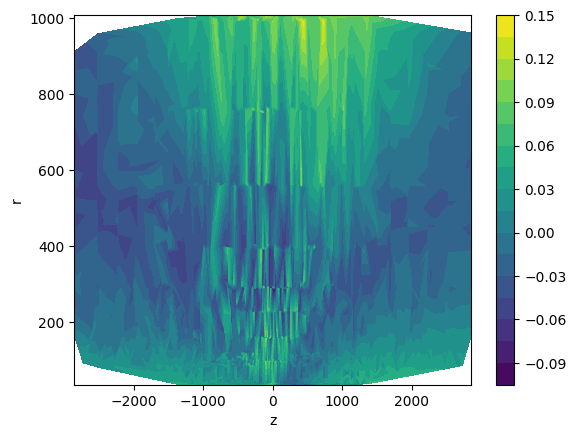

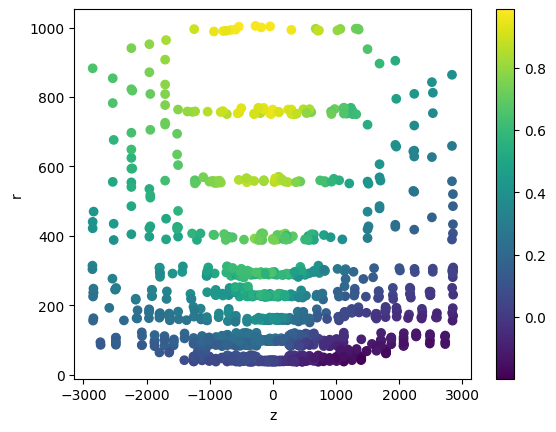

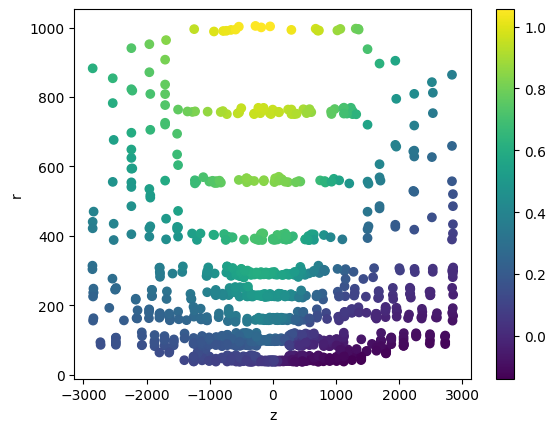

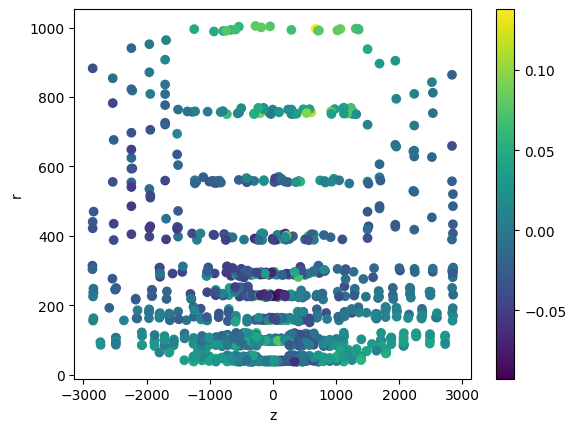

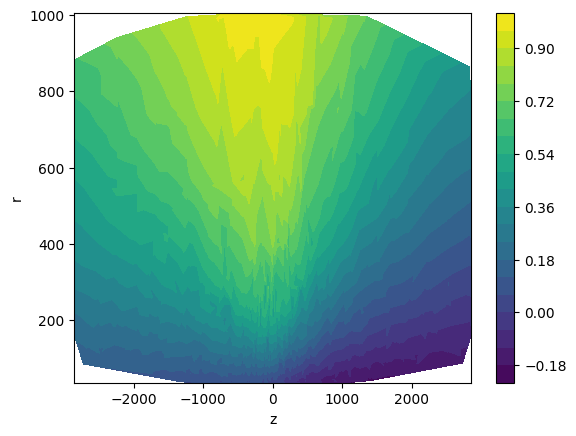

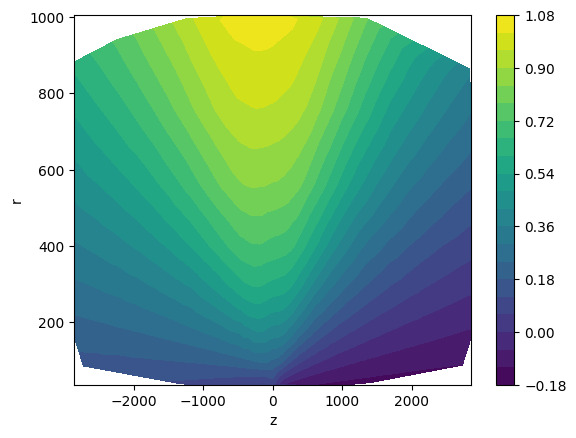

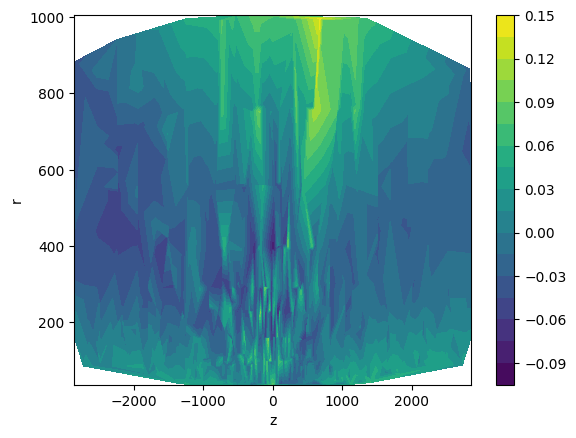

In [45]:
test_data = dataset['test_input']
columns = ["r", "phi", "z", "x", "y", "theta", "rho", "eta"]
test_data_df = pd.DataFrame(test_data.detach().numpy(), columns=columns)
# test_data_df = pd.DataFrame(test_data.detach().numpy(), columns=["r", "z"])
test_data_df["label"] = dataset['test_label'].detach().numpy()
test_data_df["predicted"] = model.predict(test_data)
# Same with the training data
train_data = dataset['train_input']
train_data_df = pd.DataFrame(train_data.detach().numpy(), columns=columns)
# train_data_df = pd.DataFrame(train_data.detach().numpy(), columns=["r", "z"])
train_data_df["label"] = dataset['train_label'].detach().numpy()
train_data_df["predicted"] = model.predict(dataset['train_input'])
from matplotlib import pyplot as plt

# Scatter Plot for Feature Pairs with Color Gradient
def plot_scatter_with_color(df, feature_x, feature_y, color_data, xlabel, ylabel):
    plt.scatter(df[feature_x], df[feature_y], c=color_data)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.colorbar()
    plt.show()


# Plot Isocurves Function
def plot_isocurves(df, feature_x, feature_y, color_data):
    plt.tricontourf(df[feature_x], df[feature_y], color_data, levels=20)
    plt.xlabel(feature_x)
    plt.ylabel(feature_y)
    plt.colorbar()
    plt.show()
    
test_data_df["predicted"] = model.predict(test_data)
plot_scatter_with_color(test_data_df, "z", "r", test_data_df["label"], "z", "r")
plot_scatter_with_color(test_data_df, "z", "r", test_data_df["predicted"], "z", "r")
plot_scatter_with_color(test_data_df, "z", "r", test_data_df["predicted"] - test_data_df["label"], "z", "r")
plot_isocurves(test_data_df, "z", "r", test_data_df["label"])
plot_isocurves(test_data_df, "z", "r", test_data_df["predicted"])
plot_isocurves(test_data_df, "z", "r", test_data_df["predicted"] - test_data_df["label"])
# Same with the training data
train_data_df["predicted"] = model.predict(dataset['train_input'])
plot_scatter_with_color(train_data_df, "z", "r", train_data_df["label"], "z", "r")
plot_scatter_with_color(train_data_df, "z", "r", train_data_df["predicted"], "z", "r")
plot_scatter_with_color(train_data_df, "z", "r", train_data_df["predicted"] - train_data_df["label"], "z", "r")
plot_isocurves(train_data_df, "z", "r", train_data_df["label"])
plot_isocurves(train_data_df, "z", "r", train_data_df["predicted"])
plot_isocurves(train_data_df, "z", "r", train_data_df["predicted"] - train_data_df["label"])

In [46]:
model.equations_

,complexity,loss,score,equation,sympy_format,lambda_format
0,1,0.081801,0.000000,sin(0.27355787),sin(0.27355787),PySRFunction(X=>sin(0.27355787))
1,2,0.045958,0.576569,0.0006823509 * x0,0.0006823509*x0,PySRFunction(X=>0.0006823509*x0)
2,3,0.032839,0.336095,(0.0013190247 * x0) * 0.6747807,0.0013190247*x0*0.6747807,PySRFunction(X=>0.0013190247*x0*0.6747807)
3,4,0.028637,0.136928,((0.0013190247 * x0) + 0.036899615) * 0.7698084,(0.0013190247*x0 + 0.036899615)*0.7698084,PySRFunction(X=>(0.0013190247*x0 + 0.036899615...
4,5,0.025972,0.097678,sin(x0 * 0.0013190247) * cos(-0.3239737),sin(x0*0.0013190247)*cos(-0.3239737),PySRFunction(X=>sin(x0*0.0013190247)*cos(-0.32...
5,6,0.025313,0.025710,sin(sin(0.0013190247 * x0)) * cos(0.0013190247),sin(sin(0.0013190247*x0))*cos(0.0013190247),PySRFunction(X=>sin(sin(0.0013190247*x0))*cos(...
6,7,0.013806,0.606171,((0.024585797 * sqrt(x6)) * sin(x5)) * 1.4807872,0.0364063334993984*sqrt(x6)*sin(x5),PySRFunction(X=>0.0364063334993984*sqrt(x6)*si...
7,8,0.005061,1.003483,sin(sin(x5 + -0.09015047) * (sqrt(x6) * 0.0380...,sin(0.038055636*sqrt(x6)*sin(x5 - 0.09015047)),PySRFunction(X=>sin(0.038055636*sqrt(x6)*sin(x...
8,9,0.004884,0.035753,((0.024585797 * sqrt(x6)) * sin((0.7548686 * -...,0.0364063334993984*sqrt(x6)*sin(x5 - 0.0968342...,PySRFunction(X=>0.0364063334993984*sqrt(x6)*si...
9,10,0.003696,0.278526,(sin(log(exp(x5 + -0.0809465))) * (sqrt(x6) * ...,0.040744122*sqrt(x6)*sin(log(0.922243030126898...,PySRFunction(X=>0.040744122*sqrt(x6)*sin(log(0...


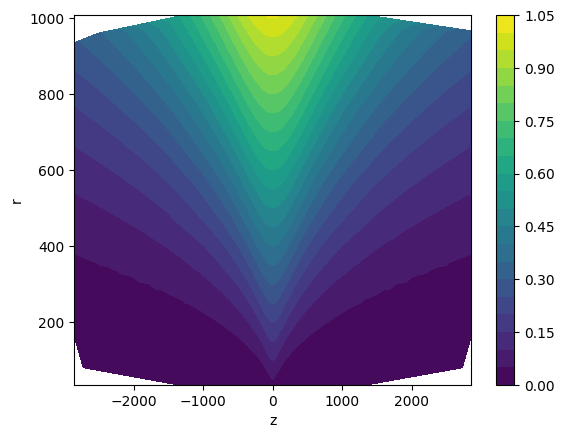

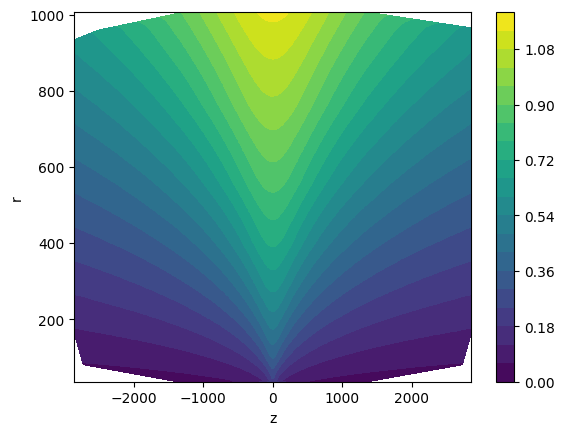

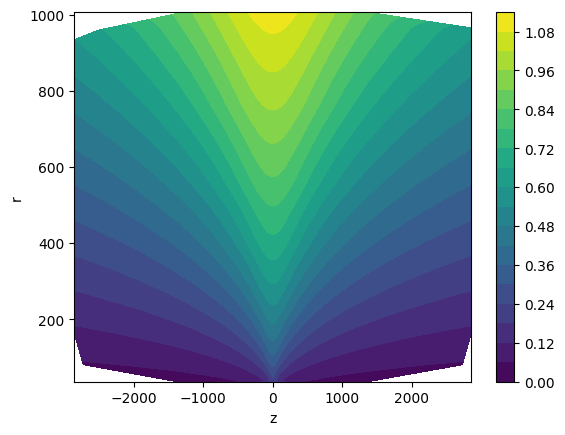

In [56]:

plot_isocurves(df, "z", "r", np.sin(df["theta"])*df["r"]/1000)
# ((0.024585797 * sqrt(x6)) * sin(x5)) * 1.4807872
# plot_isocurves(df, "z", "r", np.sin(df["theta"]) * 0.024585797 * np.sqrt(df["rho"]) * 1.4807872)
plot_isocurves(df, "z", "r", np.sin(df["theta"]) * 0.0364063334993984 * np.sqrt(df["rho"]))
# (sin(x5) * 0.03505834) * sqrt(x6)
plot_isocurves(df, "z", "r", np.sin(df["theta"]) * 0.03505834 * np.sqrt(df["rho"]))

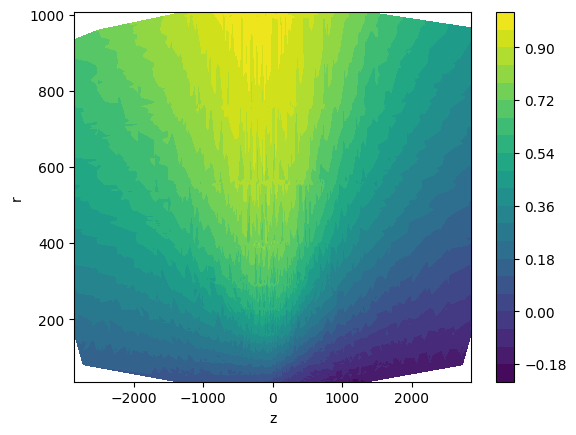

Model 0 equation: 0.4235014 * 0.63806224
MSE: 0.0818008607360416


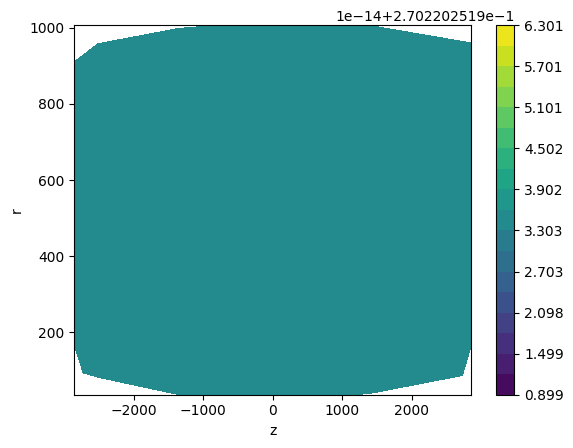

Model 1 equation: sin(x5)
MSE: 0.06446441481774846


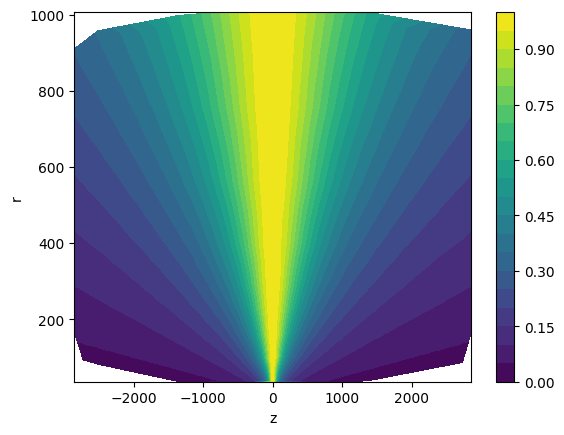

Model 2 equation: sin(x5) * 0.69962454
MSE: 0.044045421976584676


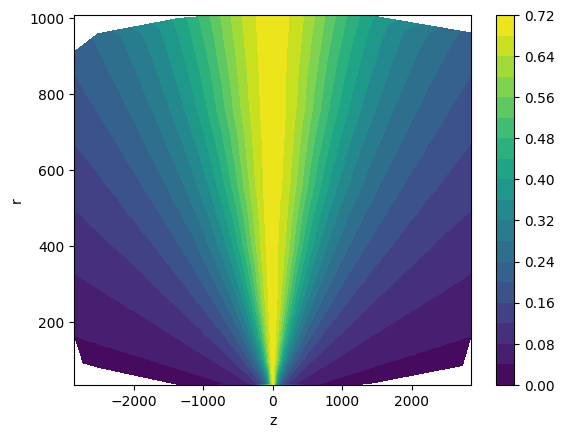

Model 3 equation: sqrt(x0) * (0.13453886 * 0.1653307)
MSE: 0.03456318178749679


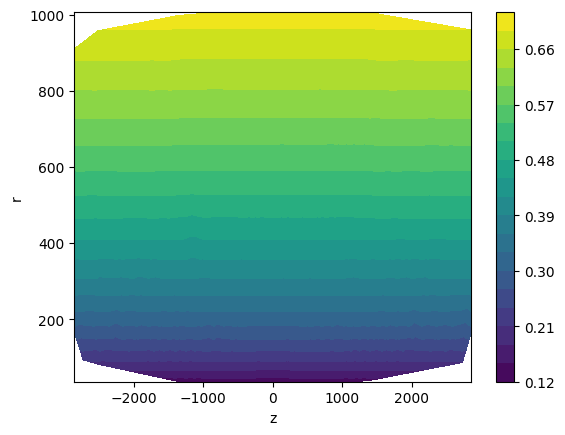

Model 4 equation: (sqrt(x0) * (0.13453886 * 0.1653307)) + -0.037466224
MSE: 0.03295138914995384


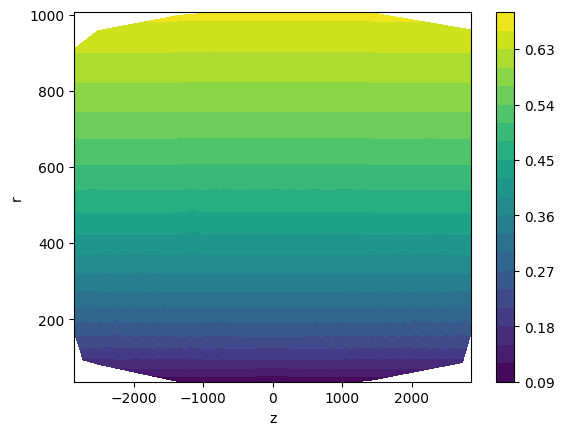

Model 5 equation: (sin(x5) * 0.03505834) * sqrt(x6)
MSE: 0.013597683124014623


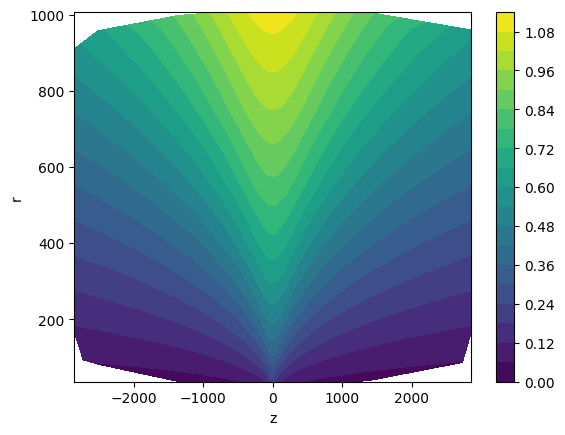

Model 6 equation: (sin(x5) * cos(1.5357323)) * sqrt(x6)
MSE: 0.013597683380881827


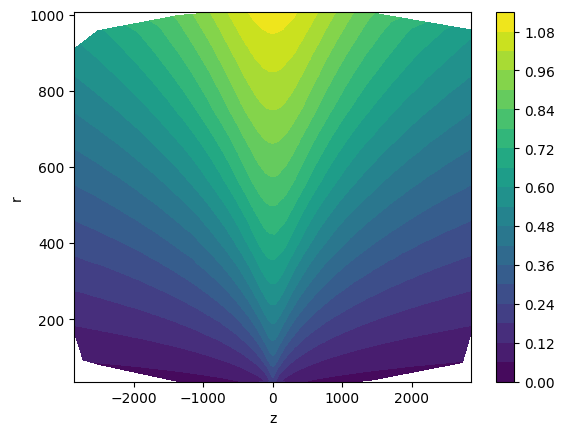

Model 7 equation: ((sin(x5) * cos(1.535625)) * sqrt(x6)) + -0.014770522
MSE: 0.013065119341518593


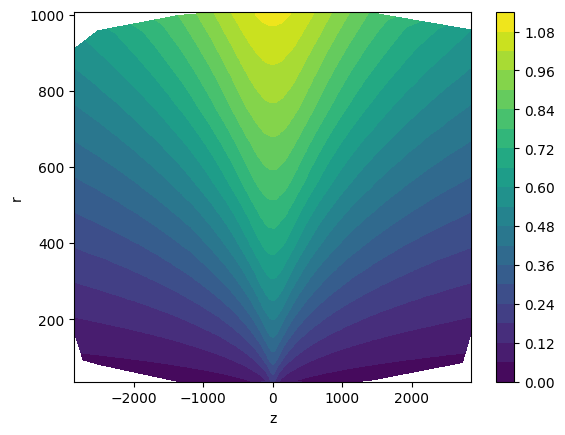

Model 8 equation: ((sin(x5 * 0.95774955) * cos(1.524796)) * sqrt(x6)) + -0.17370112
MSE: 0.00458392147048924


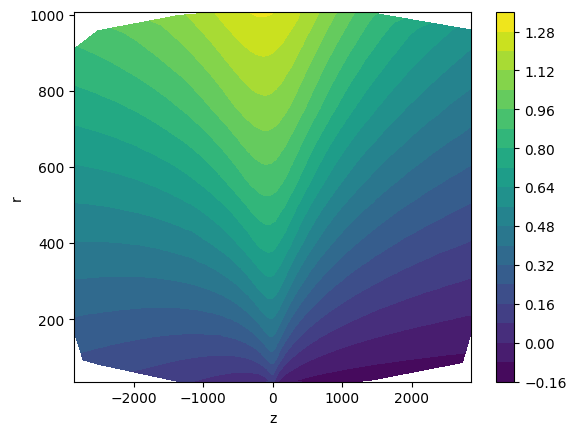

Model 9 equation: ((sin(x5 * 0.95774955) * cos(1.524796)) * sqrt(x6 + -1.8891194)) + -0.17370112
MSE: 0.004569748986945697


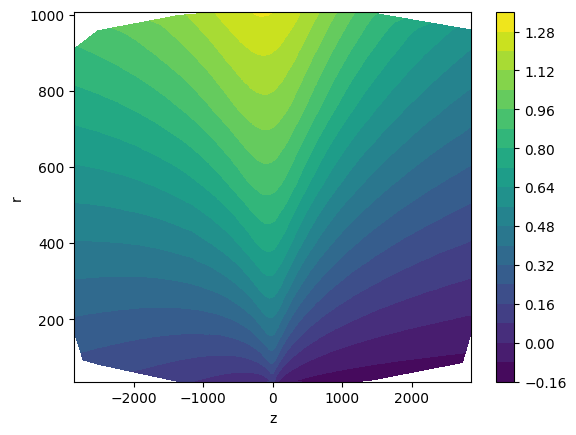

Model 10 equation: (sqrt(x6 + 1.041987) * ((sin(x5 * 0.9558515) * cos(1.529315)) * 1.0193291)) + -0.14498425
MSE: 0.003975382438807516


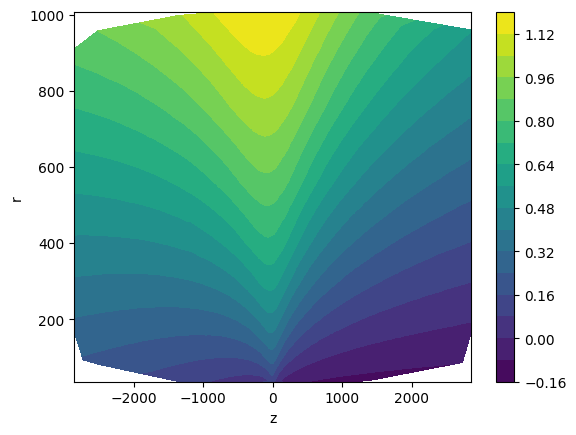

Model 11 equation: 0.12688333 * (exp(cos(log(0.7597586 * x0)) + cos(x7 * 0.59755504)) + (x7 * -0.30777332))
MSE: 0.0027033347420098784


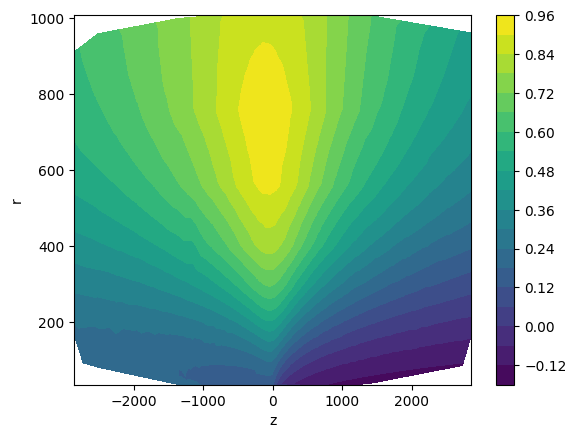

Model 12 equation: (exp(cos(x7 * -0.568424) + cos(log(x0 * 0.7776117))) + (-0.30713913 * (x7 + 0.6392579))) * 0.12944043
MSE: 0.00248466801984384


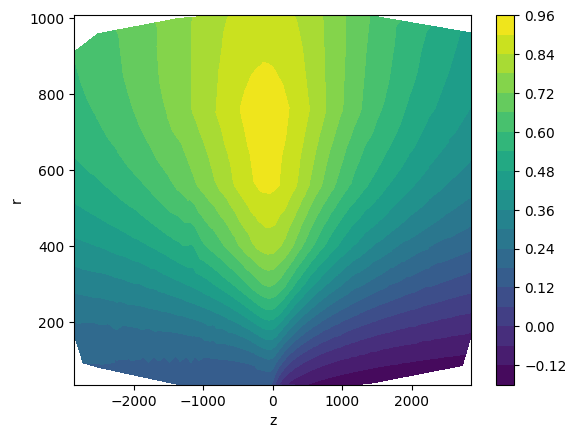

Model 13 equation: (exp(cos(x7 * -0.568424) + cos(log(x0 * 0.7776117))) + (sin(-0.30713913) * (x7 + 0.6392579))) * 0.12944043
MSE: 0.0024808132811555447


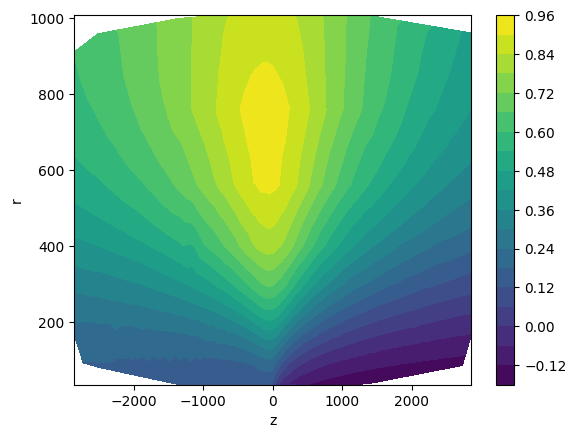

Model 14 equation: ((exp(cos(0.5517442 * x7) + cos(log(x0 + x0) * -0.85104245)) + -0.33451837) + (-0.29596972 * x7)) * 0.13119934
MSE: 0.001982953982489565


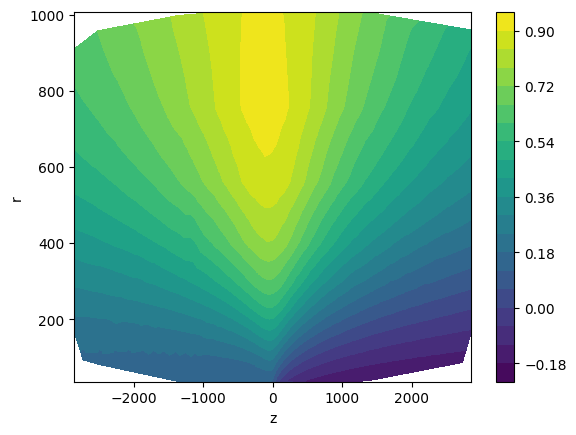

Model 15 equation: ((exp(cos(0.5517442 * (x7 + 0.1009167)) + cos(log(x0 + x0) * -0.85104245)) + -0.33451837) + (-0.29596972 * x7)) * 0.13119934
MSE: 0.0017868358986101252


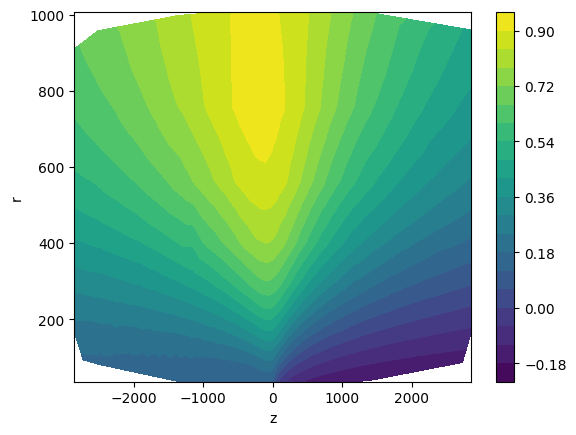

Model 16 equation: ((exp(cos(0.5517442 * (x7 + 0.1009167)) + cos(log(x0 + x0) * -0.85104245)) + -0.33451837) + sin(-0.29596972 * x7)) * 0.13119934
MSE: 0.00174699730685362


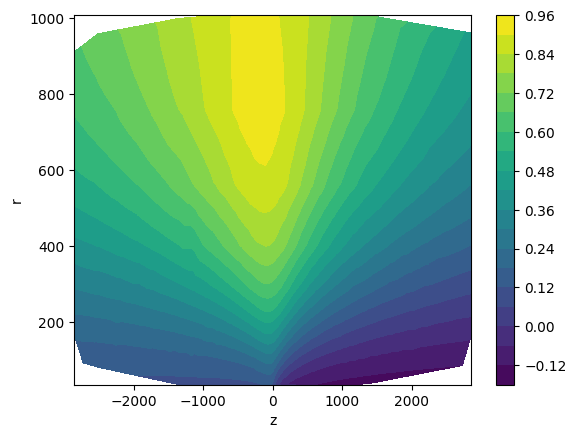

Model 17 equation: ((exp(cos(0.5517442 * (x7 + (0.1009167 * 1.4545192))) + cos(log(x0 + x0) * -0.85104245)) + -0.33451837) + sin(-0.29596972 * x7)) * 0.13119934
MSE: 0.0017212706962128036


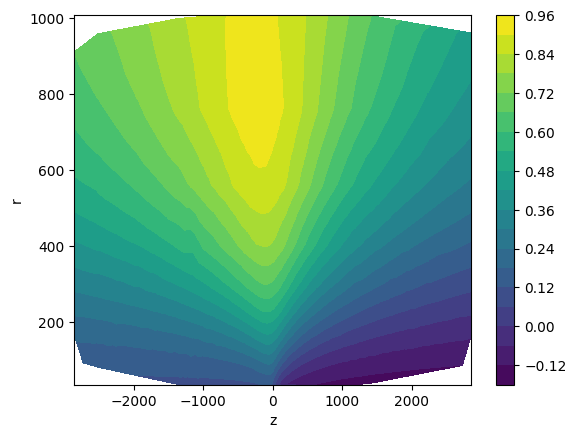

Model 18 equation: ((exp(cos((0.1009167 + x7) * 0.5517442) + cos(log((-0.4263015 + x0) + (x0 + 0.34489402)) * -0.85104245)) + -0.33451837) + ((x7 * 0.82845354) * -0.33451837)) * 0.13119934
MSE: 0.0017198483970082877


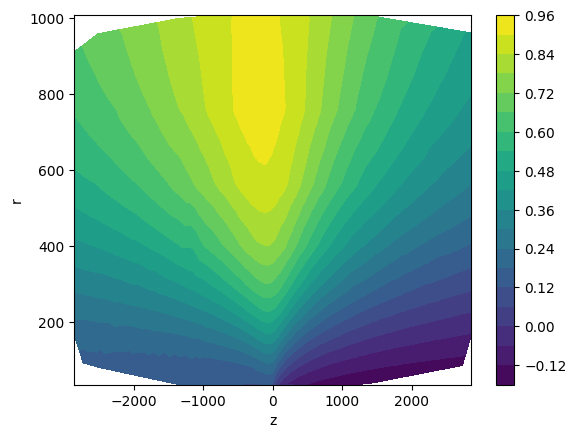

Model 19 equation: ((exp(cos((0.1009167 + x7) * 0.5517442) + cos(log((-0.4263015 + x0) + (x0 + 0.34489402)) * -0.85104245)) + -0.33451837) + (((x7 + 0.041951865) * 0.82845354) * -0.33451837)) * 0.13119934
MSE: 0.001718830277850864


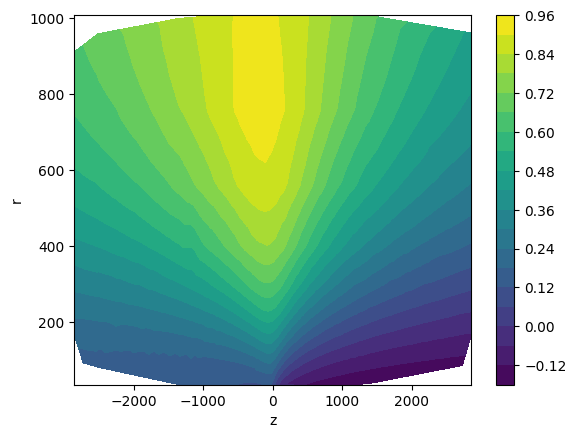

Model 20 equation: ((exp(cos((0.1009167 + x7) * 0.5517442) + cos(log((x0 + x1) + (x1 + x0)) * -0.85104245)) + -0.33451837) + ((x7 * 0.82845354) * -0.29596972)) * 0.13119934
MSE: 0.0017081765613027843


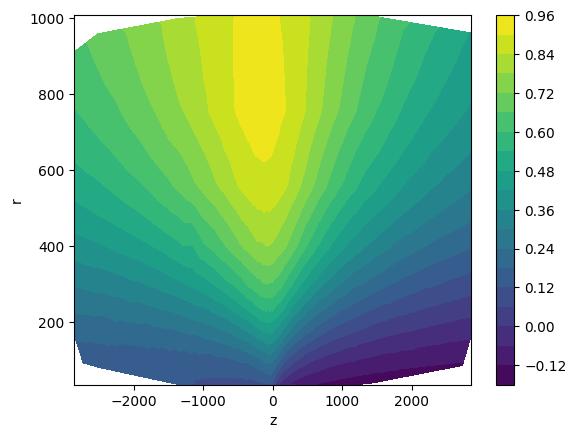

Model 21 equation: (exp(cos(log(x0 + x0) * -0.85104245) + cos((0.1009167 + x7) * 0.5517442)) + (((x7 + exp((cos(0.82845354) * -0.33451837) * x1)) * 0.82845354) * -0.33451837)) * 0.13119934
MSE: 0.001501516294151026


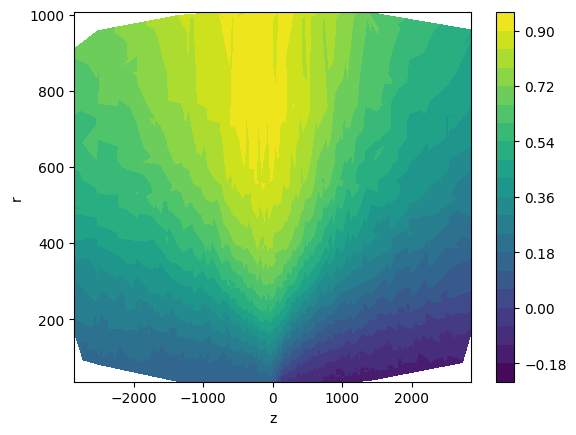

Model 22 equation: (0.1470985 * ((sin(-0.53041375 + (x7 * log(0.778834))) + exp(sin(log((x0 + ((sqrt(x0) + x3) * 0.21101286)) + x0) * -0.60441834) + cos(((sqrt(0.36265457) + x7) + -0.45092914) * log(0.6082962)))) * sqrt(1.0778006))) + -0.08659528
MSE: 0.0014848515756192208


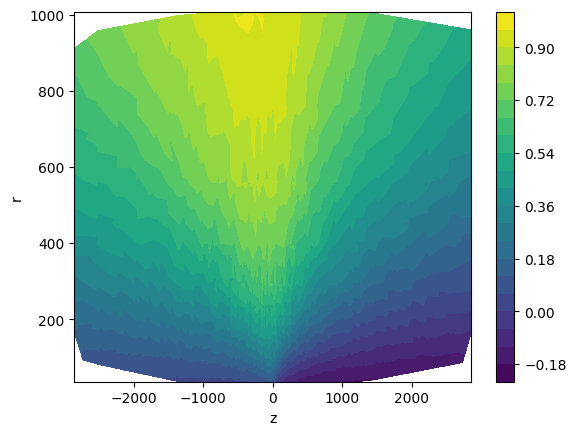

In [51]:
# Plot prediction for each model individually
plot_isocurves(df, "z", "r", label)
for i, model_ in enumerate(model.equations_["equation"]):
    print(f"Model {i} equation: {model_}")
    ypredict = model.predict(X, i)
    print("MSE:", np.power(ypredict - y, 2).mean())
    test_data_df[f"predicted_{i}"] = model.predict(test_data, i)
    plot_isocurves(test_data_df, "z", "r", test_data_df[f"predicted_{i}"])

Model 0 equation: sin(x0)
MSE: 0.02984079755660097


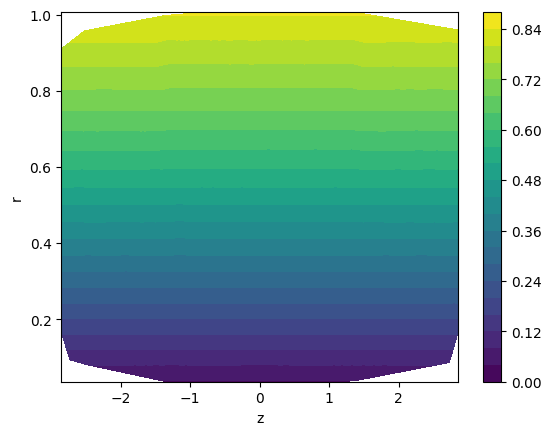

Model 1 equation: x0 + 0.03556855
MSE: 0.02866143421868342


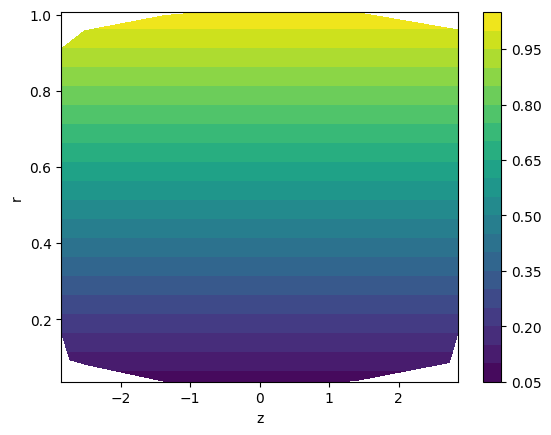

Model 2 equation: sin(1.2565663 * x0)
MSE: 0.026216724449294255


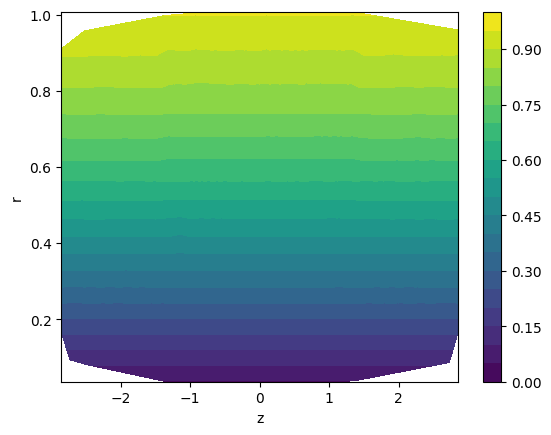

Model 3 equation: sqrt(sin(x5) * x0)
MSE: 0.014953846334979874


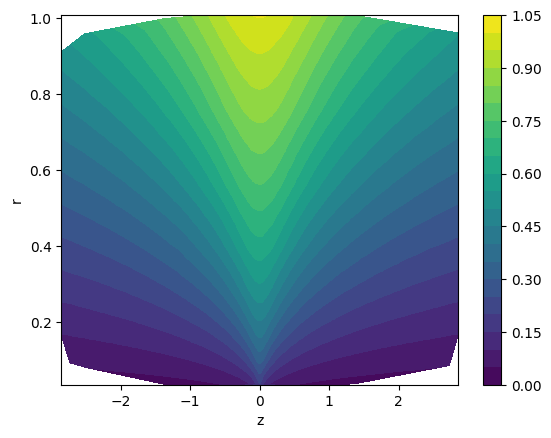

Model 4 equation: sin(x3 * exp(cos(x6)))
MSE: 0.014924641257057487


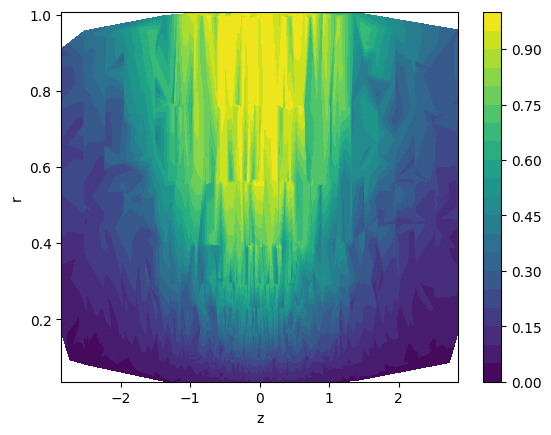

Model 5 equation: sqrt(x0 * sin(x5 * 0.89800817))
MSE: 0.009719436856176785


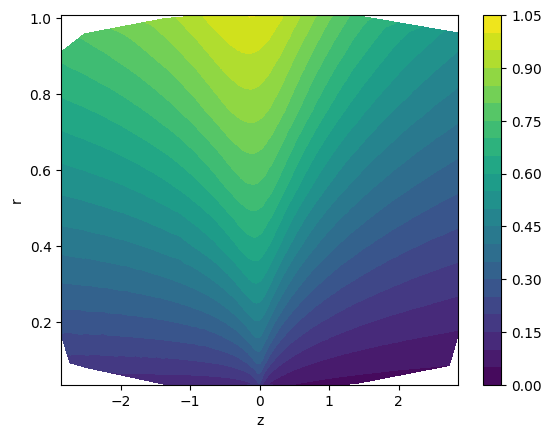

Model 6 equation: sqrt(sin(x5 * sin(x5)) * x0)
MSE: 0.00795569886041344


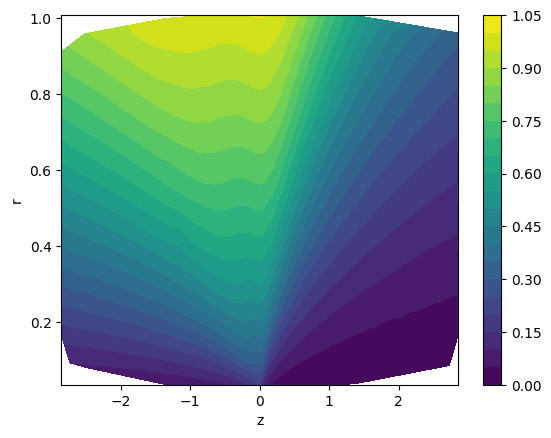

Model 7 equation: sqrt(sin(x5) * x0) + (-0.039358012 * x7)
MSE: 0.006567843531285176


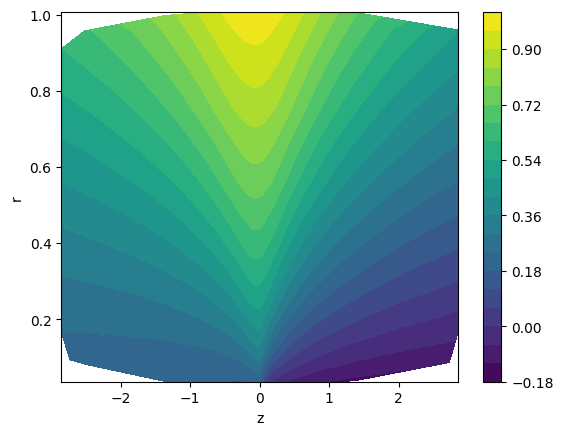

Model 8 equation: (log(x5) * 0.06898267) + sqrt(sin(x5) * x0)
MSE: 0.005487815207646738


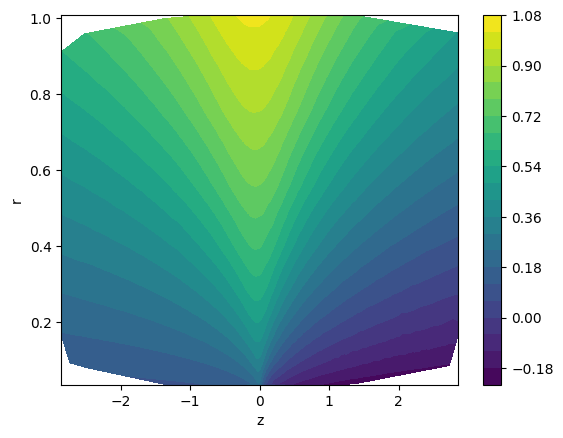

Model 9 equation: sin(x0 * (sin(sqrt(x5)) * exp(cos(sqrt(x6)))))
MSE: 0.004526687986866788


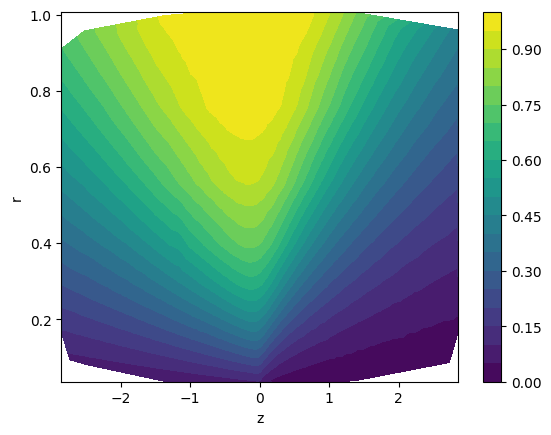

Model 10 equation: sin(sin((2.2894938 + log(sin(0.87596756 * x5))) * sin(x0)))
MSE: 0.004259072427254788


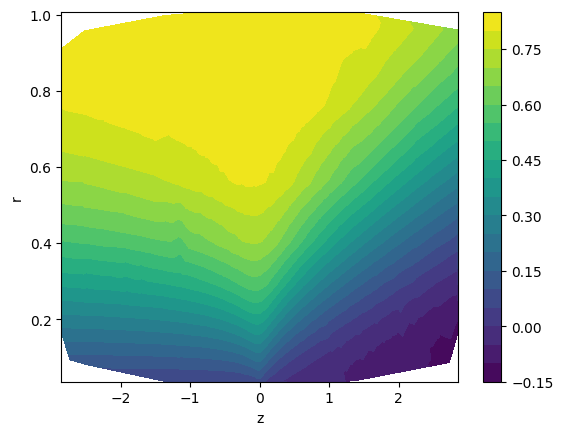

Model 11 equation: sin((x0 * cos(x0)) * (2.2894938 + log(sin(0.8883054 * x5))))
MSE: 0.0036772687627425176


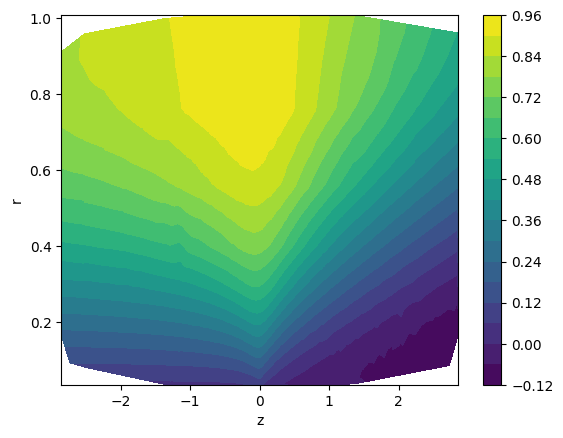

Model 12 equation: sin(sin(x0 * cos(x0)) * (2.2894938 + log(sin(0.8883054 * x5))))
MSE: 0.0032730290730648044


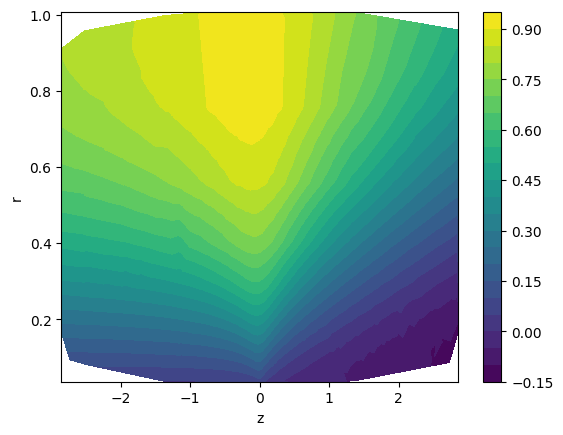

Model 13 equation: sin(sin(sin(x0 * cos(x0))) * (2.2894938 + log(sin(0.8883054 * x5))))
MSE: 0.0030686399471680026


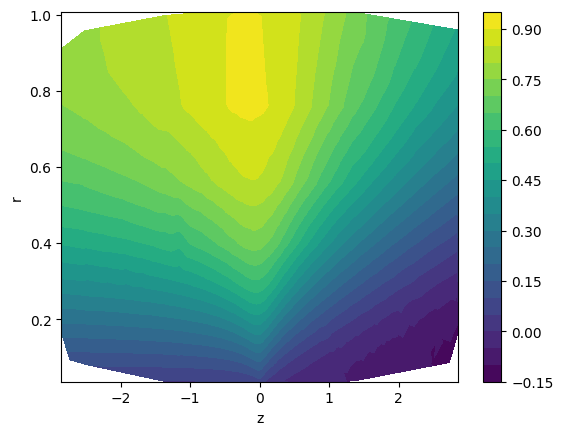

Model 14 equation: sin(sin((x0 + 0.009717659) * cos(x0)) * (2.2894938 + log(sin(0.8883054 * x5))))
MSE: 0.0030167935811168107


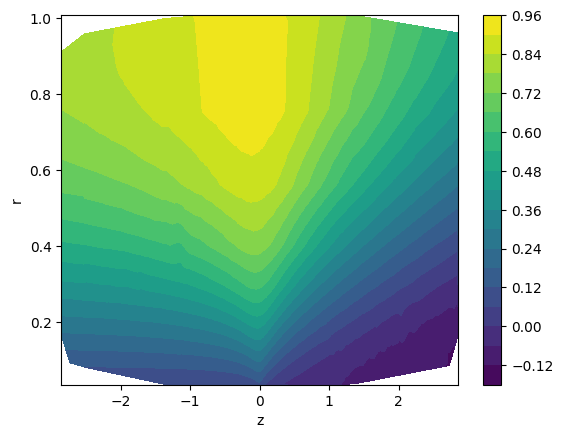

Model 15 equation: sin(sin(cos(x0) * x0) * (2.2692971 + log(sin(sqrt(sqrt(sqrt(x0))) * x5))))
MSE: 0.0029299505362345313


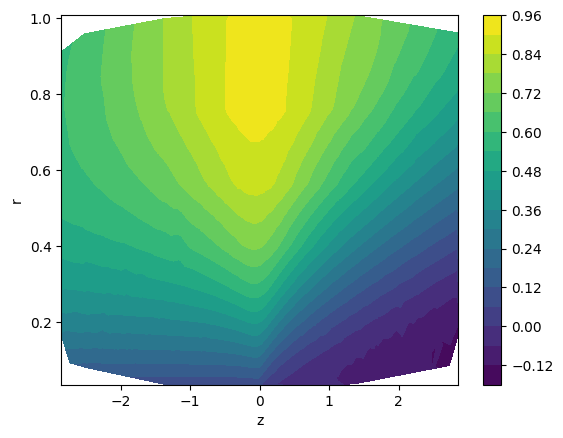

Model 16 equation: sin((2.2894938 + log(sin(sin(0.9594169) * x5))) * (sin(x0) * cos(sin(x0 * x6))))
MSE: 0.0026916413682957574


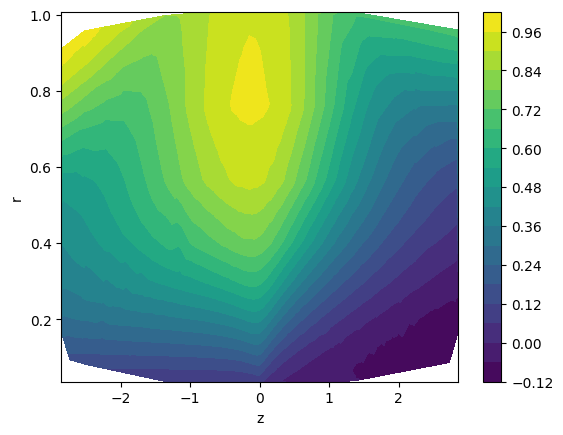

Model 17 equation: sin((2.2894938 + log(sin(sin(0.9594169) * x5))) * (sin(x0) * cos(sin(sin(x0) * x6))))
MSE: 0.0025678185710356154


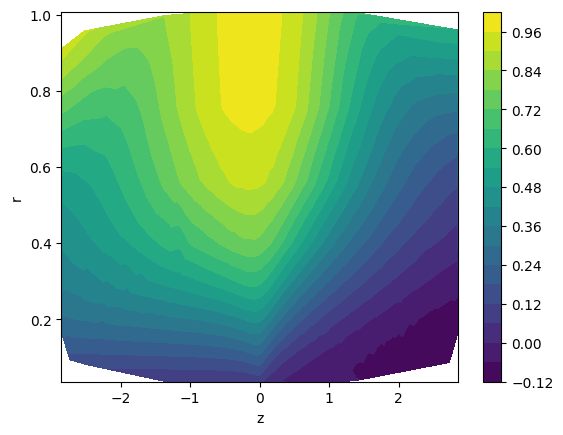

Model 18 equation: sin((cos(sqrt(x0)) * sin(sin(x0))) * ((log(sin(sqrt(sqrt(0.6886822)) * x5)) + 2.2894938) * 1.2230128))
MSE: 0.0024025973086323825


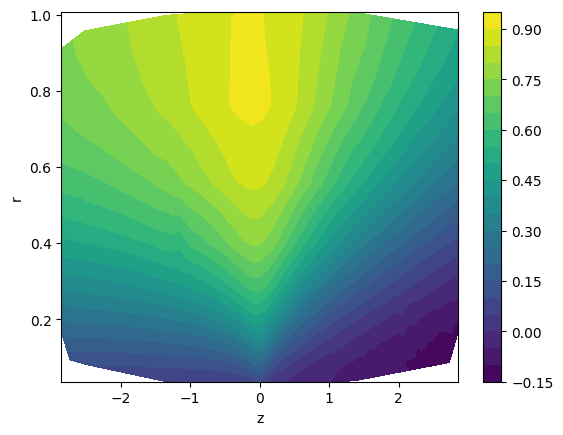

Model 19 equation: sin(sin(cos(sqrt(x0)) * sin(sin(x0))) * ((log(sin(sqrt(sqrt(0.6886822)) * x5)) + 2.2894938) * 1.2230128))
MSE: 0.0023110382970813644


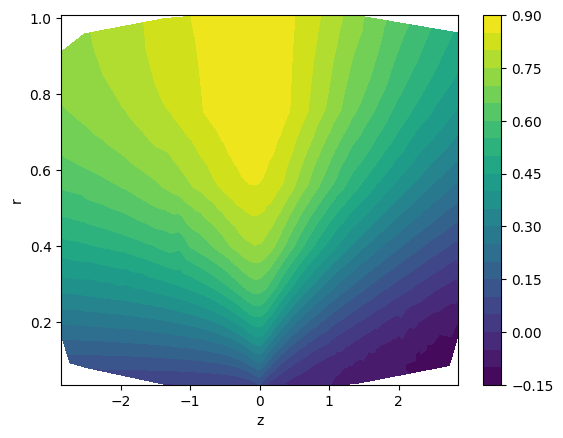

Model 20 equation: sin((2.2894938 + log(sin(sin(1.0349946) * x5))) * sin((sin(x0) * 1.0349946) * cos(sin(sin(x0) * x6))))
MSE: 0.002169822756058431


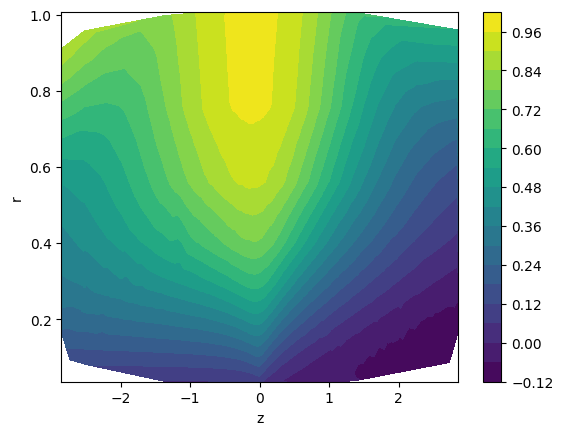

Model 21 equation: sin(sin((x0 * cos(sin(sqrt(x6 * x0)))) * ((log(sin(sin(sqrt(cos(0.6886822)) * x5))) + 2.2894938) * 1.2230128)))
MSE: 0.0021643643426947153


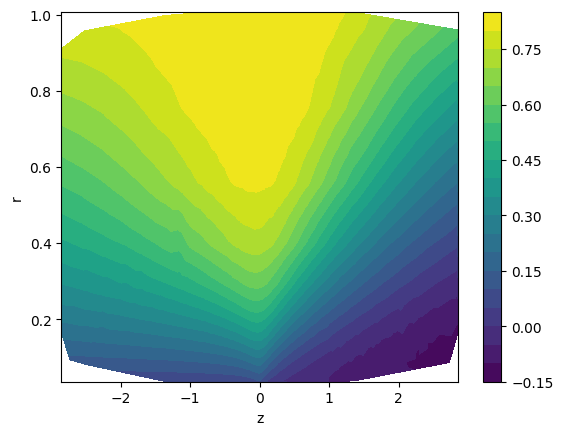

Model 22 equation: sin(sin(((log(sin(sqrt(cos(0.6886822)) * x5)) + 2.2894938) * 1.2230128) * (sin(x0) * cos(sin(sqrt(x6 * sin(x0)))))))
MSE: 0.0020972125699975854


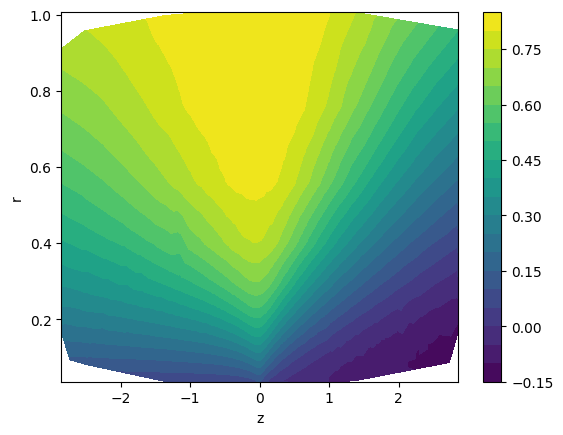

Model 23 equation: sin(sin(cos(sqrt(sqrt(sin(x0) * x6))) * sin(x0)) * (1.2230128 * (2.2894938 + log(sin(cos(sin(sin(0.6478449))) * x5)))))
MSE: 0.0020354860907913813


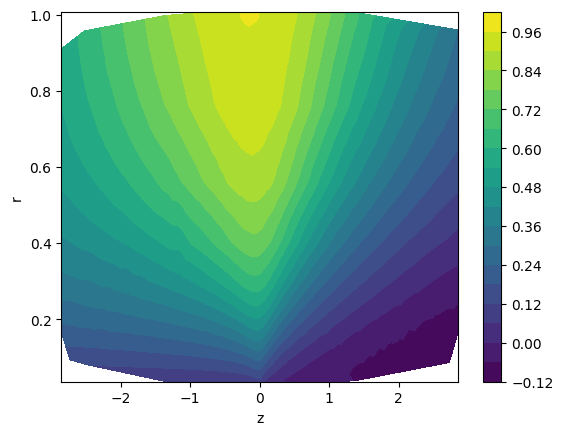

Model 24 equation: sin(sin(sin(cos(sqrt(sin(x0 * x6))) * sin(x0))) * ((log(sin(sin(sqrt(sqrt(sin(0.6886822))) * x5))) + 2.2894938) * 1.2230128))
MSE: 0.001919451318326403


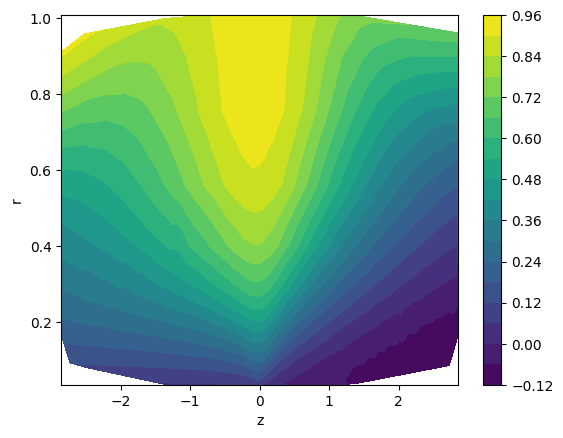

Model 25 equation: sin(sin(sin(sin(cos(sqrt(sin(x0 * x6))) * sin(x0)))) * ((log(sin(sin(sqrt(sqrt(sin(0.6478449))) * x5))) + 2.2894938) * 1.2230128))
MSE: 0.0018244019617319764


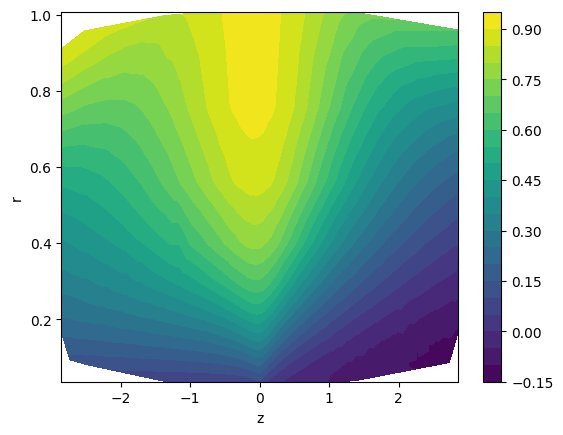

Model 26 equation: sin(sin(sin(sin(sin(sin(cos(sqrt(sin((x0 * 0.9610765) * x6))) * x0))))) * ((log(sin(sin(sqrt(sqrt(sin(0.6478449))) * x5))) + 2.2894938) * 1.2230128))
MSE: 0.0017862229770289658


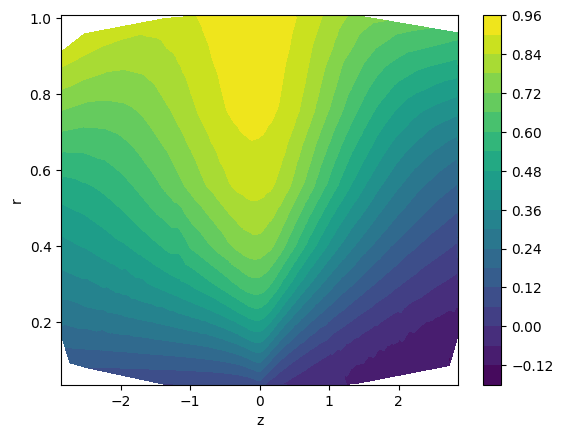

In [27]:
# Plot prediction for each model individually
for i, model_ in enumerate(model.equations_["equation"]):
    print(f"Model {i} equation: {model_}")
    ypredict = model.predict(X, i)
    print("MSE:", np.power(ypredict - y, 2).mean())
    test_data_df[f"predicted_{i}"] = model.predict(test_data, i)
    plot_isocurves(test_data_df, "z", "r", test_data_df[f"predicted_{i}"])

# Custom operators

A full list of operators is given here: https://astroautomata.com/PySR/operators,
but we can also use any binary or unary operator in `julia`, or define our own as arbitrary functions.

Say that we want a command to do quartic powers:

$$ y = x_0^4 - 2 $$

In [11]:
y = X[:, 0] ** 4 - 2

We can do this by passing a string in Julia syntax.

We also define the operator in sympy, with `extra_sympy_mappings`, to enable its use in `predict`, and other export functions.

In [12]:
model = PySRRegressor(
    niterations=5,
    populations=40,
    binary_operators=["+", "*"],
    unary_operators=["cos", "exp", "sin", "quart(x) = x^4"],
    extra_sympy_mappings={"quart": lambda x: x**4},
)
model.fit(X, y)

/home/couthures/anaconda3/envs/ML/lib/python3.11/site-packages/pysr/sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!


PySRRegressor.equations_ = [
	   pick      score                                           equation  \
	0         0.000000                                                 x1   
	1         8.415255                                          quart(x0)   
	2  >>>>  12.155711                             quart(x0) + -1.9999998   
	3         0.000050         -1.9999999 + (cos(-131.94688) * quart(x0))   
	4         0.000008  (quart(x0) + -1.9965879) + ((cos(-1.085663) * ...   
	
	           loss  complexity  
	0  1.806171e+04           1  
	1  3.999999e+00           2  
	2  1.105970e-10           4  
	3  1.105805e-10           7  
	4  1.105763e-10          12  
]

In [13]:
model.sympy()

x0**4 - 1.9999998

Since `quart` is arguably more complex than the other operators, you can also give it a different complexity, using, e.g., `complexity_of_operators={"quart": 2}` to give it a complexity of 2 (instead of the default 1). You can also define custom complexities for variables and constants (`complexity_of_variables` and `complexity_of_constants`, respectively - both take a single number).


One can also add a binary operator, with, e.g., `"myoperator(x, y) = x^2 * y"`. All Julia operators that work on scalar 32-bit floating point values are available.

Make sure that any operator you add is valid over the real line. So, e.g., you will need to define `"mysqrt(x) = sqrt(abs(x))"` to enable it for negative numbers,
or, simply have it return a very large number for bad inputs (to prevent negative input in a soft way):
`"mysqrt(x::T) where {T} = (x >= 0) ? x : T(-1e9)"` (Julia syntax for a template function of input type `T`), which will make `mysqrt(x)` return -10^9 for negative x–hurting the loss of the equation.

## Scoring

Using `model_selection="best"`selects the equation with the max score and prints it. But in practice it is best to look through all the equations manually, select an equation above some MSE threshold, and then use the score to select among that loss threshold.

Here, "score" is defined by:
$$ \text{score} = - \log(\text{loss}_i/\text{loss}_{i-1})/
(\text{complexity}_i - \text{complexity}_{i-1})$$

This scoring is motivated by the common strategy of looking for drops in the loss-complexity curve.

From Schmidt & Lipson (2009) -

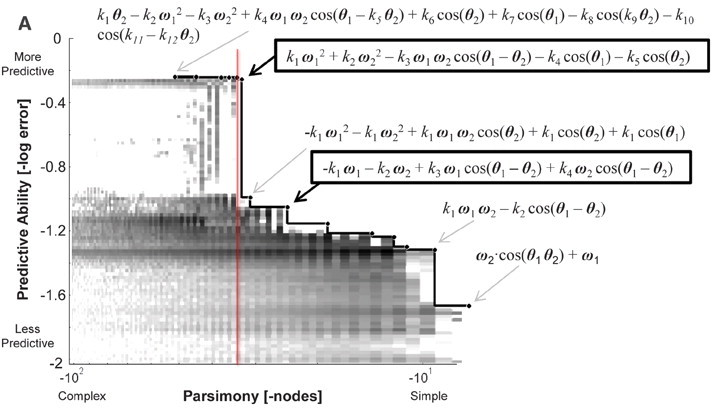

# Noise example

Here is an example with noise. Known Gaussian noise with $\sigma$ between 0.1 and 5.0. We record samples of $y$:

$$ \sigma \sim U(0.1, 5.0) $$
$$ \epsilon \sim \mathcal{N}(0, \sigma^2)$$
$$ y = 5\;\cos(3.5 x_0) - 1.3 + \epsilon.$$
We have 5 features, say. The weights change the loss function to be:
$$MSE = \sum [(y - f(x))^2*w],$$

so in this example, we can set:
$$w = 1/\sigma^2.$$

In [14]:
np.random.seed(0)
N = 3000
upper_sigma = 5
X = 2 * np.random.rand(N, 5)
sigma = np.random.rand(N) * (5 - 0.1) + 0.1
eps = sigma * np.random.randn(N)
y = 5 * np.cos(3.5 * X[:, 0]) - 1.3 + eps

Let's look at this dataset:

Text(0, 0.5, '$y$')

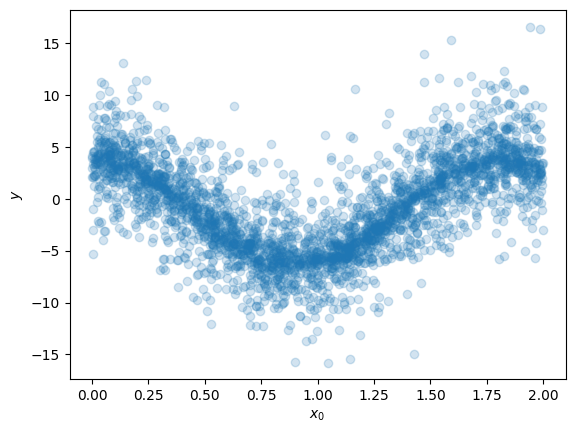

In [15]:
plt.scatter(X[:, 0], y, alpha=0.2)
plt.xlabel("$x_0$")
plt.ylabel("$y$")

Define some weights to use:

In [16]:
weights = 1 / sigma**2

In [17]:
weights[:5]

array([0.25199296, 0.0775419 , 0.11515701, 0.1781281 , 0.0448131 ])

Let's run PySR again:

In [18]:
model = PySRRegressor(
    elementwise_loss="myloss(x, y, w) = w * abs(x - y)",  # Custom loss function with weights.
    niterations=20,
    populations=20,  # Use more populations
    binary_operators=["+", "*"],
    unary_operators=["cos"],
)
model.fit(X, y, weights=weights)

/home/couthures/anaconda3/envs/ML/lib/python3.11/site-packages/pysr/sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 3.970e+04
Head worker occupation: 11.9%
Progress: 92 / 400 total iterations (23.000%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           3.305e+00  1.594e+01  y = -1.2942
3           3.183e+00  1.875e-02  y = -2.0854 + x₀
4           2.749e+00  1.466e-01  y = cos(3.2318 * x₀)
6           1.448e+00  3.208e-01  y = cos(x₀ * 3.5662) * 3.5662
8           3.411e-01  7.227e-01  y = (4.9463 * cos(3.5214 * x₀)) + -1.2942
12          3.126e-01  2.185e-02  y = (((2.0389 + 1.556) + 1.4317) * cos(3.4959 * x₀)) + -1.2909
18          3.126e-01  1.729e-06  y = (cos(x₀ + (x₀ + (x₀ * (1.803 + -0.30722)))) * ((1.6757 + 1...
                                  .6757) + 1.6757)) + -1.2899
19          3.126e-01  5.907e-05  y = (cos(3.4956 * x₀) * (cos(cos(cos(-0.065205) + -0.26198)) +...
                                   ((1.7897 + 1.3098) + 1.1872))) + -1.2

PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                          -1.184887   
	1         0.018599                                    -2.0869544 + x0   
	2         0.148813                                cos(3.3334923 * x0)   
	3         0.454044                     5.024011 * cos(3.3228724 * x0)   
	4   >>>>  0.631961      (cos(x0 * 3.4959137) * 5.033307) + -1.2866523   
	5         0.000009  (cos(x0 * 3.4957967) * (4.3585644 + 0.6713176)...   
	6         0.000004  (-2.2722473 + (5.02952 * cos(3.4959054 * x0)))...   
	7         0.001335  ((5.034819 * cos(x0 * 3.4952705)) + -1.2893057...   
	8         0.001097  (cos(x2) * -0.022214422) + (5.031575 * (cos(x0...   
	9         0.000549  ((-2.2770479 + (5.030123 * cos(3.4968417 * x0)...   
	10        0.001034  (-1.276383 + (cos(x0 * 3.486218) * 4.025189)) ...   
	
	        loss  complexity  
	0   3.304066           1  
	1   3.183421           3  
	2   2.743251           4  
	3   1.106339           6  
	4   0.312589           8  
	5   0.312583          10  
	6   0.312582          11  
	7   0.312165          12  
	8   0.311823          13  
	9   0.311480          15  
	10  0.310837          17  
]

Let's see if we get similar results to the true equation

In [19]:
model

PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                          -1.184887   
	1         0.018599                                    -2.0869544 + x0   
	2         0.148813                                cos(3.3334923 * x0)   
	3         0.454044                     5.024011 * cos(3.3228724 * x0)   
	4   >>>>  0.631961      (cos(x0 * 3.4959137) * 5.033307) + -1.2866523   
	5         0.000009  (cos(x0 * 3.4957967) * (4.3585644 + 0.6713176)...   
	6         0.000004  (-2.2722473 + (5.02952 * cos(3.4959054 * x0)))...   
	7         0.001335  ((5.034819 * cos(x0 * 3.4952705)) + -1.2893057...   
	8         0.001097  (cos(x2) * -0.022214422) + (5.031575 * (cos(x0...   
	9         0.000549  ((-2.2770479 + (5.030123 * cos(3.4968417 * x0)...   
	10        0.001034  (-1.276383 + (cos(x0 * 3.486218) * 4.025189)) ...   
	
	        loss  complexity  
	0   3.304066           1  
	1   3.183421           3  
	2   2.743251           4  
	3   1.106339           6  
	4   0.312589           8  
	5   0.312583          10  
	6   0.312582          11  
	7   0.312165          12  
	8   0.311823          13  
	9   0.311480          15  
	10  0.310837          17  
]

We can also filter all equations up to 2x the most accurate equation, then select the best score from that list:

In [20]:
best_idx = model.equations_.query(
    f"loss < {2 * model.equations_.loss.min()}"
).score.idxmax()
model.sympy(best_idx)

cos(x0*3.4959137)*5.033307 - 1.2866523

We can also use `denoise=True`, which will run the input through a Gaussian process to denoise the dataset, before fitting on it.

Let's look at the fit:

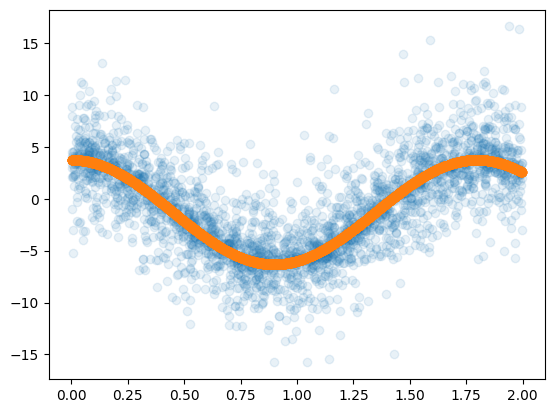

In [21]:
plt.scatter(X[:, 0], y, alpha=0.1)
y_prediction = model.predict(X, index=best_idx)
plt.scatter(X[:, 0], y_prediction)

# Multiple outputs

For multiple outputs, multiple equations are returned:

In [22]:
X = 2 * np.random.randn(100, 5)
y = 1 / X[:, [0, 1, 2]]

In [23]:
model = PySRRegressor(
    binary_operators=["+", "*"],
    unary_operators=["inv(x) = 1/x"],
    extra_sympy_mappings={"inv": lambda x: 1 / x},
)
model.fit(X, y)

/home/couthures/anaconda3/envs/ML/lib/python3.11/site-packages/pysr/sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 3.760e+05
Head worker occupation: 23.1%
Progress: 813 / 1800 total iterations (45.167%)
Best equations for output 1
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
2           3.991e-14  7.971e+00  y₀ = inv(x₀)
---------------------------------------------------------------------------------------------------
Best equations for output 2
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           6.368e+02  1.594e+01  y₁ = x₁
2           2.336e-12  1.594e+01  y₁ = inv(x₁)
11          5.138e-14  4.241e-01  y₁ = ((x₀ * inv(x₁ * x₀)) + inv(149.86)) + -0.0066727
---------------------------------------------------------------------------------------------------
Best equations for output 3
Hall of Fame:
-------------------------------------------

PySRRegressor.equations_ = [
[
	   pick      score equation          loss  complexity
	0         0.000000       x3  5.499681e+01           1
	1  >>>>  34.859306  inv(x0)  3.991474e-14           2
], [
	   pick      score                                           equation  \
	0         0.000000                                          0.3105893   
	1        33.237640                                            inv(x1)   
	2  >>>>   0.424108  ((x0 * inv(x1 * x0)) + inv(149.86417)) + -0.00...   
	
	           loss  complexity  
	0  6.358884e+02           1  
	1  2.335916e-12           2  
	2  5.137668e-14          11  
], [
	   pick  score equation          loss  complexity
	0  >>>>    0.0  inv(x2)  1.490184e-10           2
]]

In [24]:
model

PySRRegressor.equations_ = [
[
	   pick      score equation          loss  complexity
	0         0.000000       x3  5.499681e+01           1
	1  >>>>  34.859306  inv(x0)  3.991474e-14           2
], [
	   pick      score                                           equation  \
	0         0.000000                                          0.3105893   
	1        33.237640                                            inv(x1)   
	2  >>>>   0.424108  ((x0 * inv(x1 * x0)) + inv(149.86417)) + -0.00...   
	
	           loss  complexity  
	0  6.358884e+02           1  
	1  2.335916e-12           2  
	2  5.137668e-14          11  
], [
	   pick  score equation          loss  complexity
	0  >>>>    0.0  inv(x2)  1.490184e-10           2
]]

# Julia packages and types

PySR uses [SymbolicRegression.jl](https://github.com/MilesCranmer/SymbolicRegression.jl)
as its search backend. This is a pure Julia package, and so can interface easily with any other
Julia package.
For some tasks, it may be necessary to load such a package.

For example, let's say we wish to discovery the following relationship:

$$ y = p_{3x + 1} - 5, $$

where $p_i$ is the $i$th prime number, and $x$ is the input feature.

Let's see if we can discover this using
the [Primes.jl](https://github.com/JuliaMath/Primes.jl) package.



`jl` stores the Julia runtime.

Now, let's run some Julia code to add the Primes.jl
package to the PySR environment:

In [25]:
from pysr import jl

jl.seval(
    """
import Pkg
Pkg.add("Primes")
"""
)

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed IntegerMathUtils ─ v0.1.2
   Installed Primes ─────────── v0.5.6
    Updating `~/anaconda3/envs/ML/julia_env/Project.toml`
  [27ebfcd6] + Primes v0.5.6
    Updating `~/anaconda3/envs/ML/julia_env/Manifest.toml`
  [18e54dd8] + IntegerMathUtils v0.1.2
  [27ebfcd6] + Primes v0.5.6
Precompiling project...
  ✓ IntegerMathUtils
  ✓ Primes
  2 dependencies successfully precompiled in 1 seconds. 82 already precompiled.


This imports the Julia package manager, and uses it to install
`Primes.jl`. Now let's import `Primes.jl`:

In [26]:
jl.seval("using Primes: prime")

Note that PySR should automatically load the `juliacall.ipython` extension for you,
which means that you can also execute Julia code in the notebook using the `%%julia` magic:

In [27]:
%julia using Primes: prime


Now, we define a custom operator:


In [28]:
jl.seval(
    """
function p(i::T) where T
    if 0.5 < i < 1000
        return T(prime(round(Int, i)))
    else
        return T(NaN)
    end
end
"""
)

p (generic function with 1 method)

Or, equivalently:

In [29]:
%%julia
function p(i::T) where T
    if 0.5 < i < 1000
        return T(prime(round(Int, i)))
    else
        return T(NaN)
    end
end

p (generic function with 1 method)


We have created a function `p`, which takes a number `i` of type `T` (e.g., `T=Float64`).
`p` first checks whether the input is between 0.5 and 1000.
If out-of-bounds, it returns `NaN`.
If in-bounds, it rounds it to the nearest integer, computes the corresponding prime number, and then
converts it to the same type as input.

The equivalent function in Python would be:

```python
import sympy

def p(i):
    if 0.5 < i < 1000:
        return float(sympy.prime(int(round(i))))
    else:
        return float("nan")
```

(However, note that this version assumes 64-bit float input, rather than any input type `T`)

Next, let's generate a list of primes for our test dataset.
Since we are using juliacall, we can just call `p` directly to do this:


In [30]:
primes = {i: jl.p(i * 1.0) for i in range(1, 999)}

Next, let's use this list of primes to create a dataset of $x, y$ pairs:

In [31]:
import numpy as np

X = np.random.randint(0, 100, 100)[:, None]
y = [primes[3 * X[i, 0] + 1] - 5 + np.random.randn() * 0.001 for i in range(100)]

Note that we have also added a tiny bit of noise to the dataset.

Finally, let's create a PySR model, and pass the custom operator. We also need to define the sympy equivalent, which we can leave as a placeholder for now:

In [32]:
from pysr import PySRRegressor
import sympy


class sympy_p(sympy.Function):
    pass


model = PySRRegressor(
    binary_operators=["+", "-", "*", "/"],
    unary_operators=["p"],
    niterations=20,
    extra_sympy_mappings={"p": sympy_p},
)

We are all set to go! Let's see if we can find the true relation:

In [33]:
model.fit(X, y)

/home/couthures/anaconda3/envs/ML/lib/python3.11/site-packages/pysr/sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 3.290e+04
Head worker occupation: 4.9%
Progress: 72 / 300 total iterations (24.000%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
2           1.070e+06  7.971e+00  y = p(1.6534)
3           1.147e+04  4.536e+00  y = 20.007 * x₀
5           7.682e+02  1.352e+00  y = -103.47 + (x₀ * 20.007)
7           2.500e+01  1.713e+00  y = p((p(1.6534) * x₀) + 1.356)
9           5.141e+00  7.908e-01  y = p((x₀ * p(2.4963)) + 0.90351) + -2.7326
10          1.109e-06  1.491e+01  y = p(((0.6352 + x₀) + x₀) + x₀) - 5
18          1.096e-06  1.534e-03  y = (-2.0924 + (((p((x₀ - -0.33258) * p(1.6308)) + p(0.76136))...
                                   - 0.79122) - 1.9403)) + -2.1761
20          1.083e-06  5.631e-03  y = ((((0.16025 * x₀) + p((x₀ + x₀) + (x₀ - -1.0814))) + (-1.1...
                                  603 * x₀)) + x₀) + -4.9998
---------------------

PySRRegressor.equations_ = [
	   pick      score                                           equation  \
	0         0.000000                                       -0.046659198   
	1         0.119835                                       p(20.006845)   
	2         5.715006                                      18.38656 * x0   
	3         0.704810                      -103.47014 + (x0 * 20.006845)   
	4         1.712603                 p((p(1.6533508) * x0) + 1.3560388)   
	5         0.236913         -9.328299 + p((1.0167496 + x0) * 2.975661)   
	6  >>>>  16.693873      p((p(1.8574193) * x0) - -1.077219) - 4.999977   
	7         0.001363  (-2.0923672 + (((p((x0 - -0.33258373) * p(1.63...   
	8         0.005631  ((((0.16025293 * x0) + p((x0 + x0) + (x0 - -1....   
	
	           loss  complexity  
	0  1.075756e+06           1  
	1  9.542669e+05           2  
	2  3.145389e+03           3  
	3  7.682170e+02           5  
	4  2.499978e+01           7  
	5  1.972632e+01           8  
	6  1.109147e-06           9  
	7  1.095627e-06          18  
	8  1.083356e-06          20  
]

if all works out, you should be able to see the true relation (note that the constant offset might not be exactly 1, since it is allowed to round to the nearest integer).

You can get the sympy version of the best equation with:

In [34]:
model.sympy()

sympy_p(x0*sympy_p(1.8574193) - 1*(-1.077219)) - 1*4.999977

# High-dimensional input: Neural Nets + Symbolic Regression

In this example, let's learn a high-dimensional problem. **This will use the method proposed in our NeurIPS paper: https://arxiv.org/abs/2006.11287.**

Let's consider a time series problem:

$$ z = y^2,\quad y = \frac{1}{10} \sum(y_i),\quad y_i = x_{i0}^2 + 6 \cos(2*x_{i2})$$

Imagine our time series is 10 timesteps. That is very hard for symbolic regression, even if we impose the inductive bias of $$z=f(\sum g(x_i))$$ - it is the square of the number of possible equations!

But, as in our paper, **we can break this problem down into parts with a neural network. Then approximate the neural network with the symbolic regression!**

Then, instead of, say, $(10^9)^2=10^{18}$ equations, we only have to consider $2\times 10^9$ equations.

In [35]:
import numpy as np

rstate = np.random.RandomState(0)

N = 100000
Nt = 10
X = 6 * rstate.rand(N, Nt, 5) - 3
y_i = X[..., 0] ** 2 + 6 * np.cos(2 * X[..., 2])
y = np.sum(y_i, axis=1) / y_i.shape[1]
z = y**2
X.shape, y.shape

((100000, 10, 5), (100000,))

## Neural Network definition

So, as described above, let's first use a neural network with the sum inductive bias to solve this problem.

Essentially, we will learn two neural networks:
- `f`
- `g`

each defined as a multi-layer perceptron. We will sum over `g` the same way as in our equation, but we won't define the summed part beforehand.

Then, we will fit `g` and `f` **separately** using symbolic regression.

> **Warning**
>
> We import torch *after* already starting PyJulia. This is required due to interference between their C bindings. If you use torch, and then run PyJulia, you will likely hit a segfault. So keep this in mind for mixed deep learning + PyJulia/PySR workflows.

In [36]:
!pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://packagecloud.io/github/git-lfs/pypi/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 903.9 kB/s eta 0:00:0000:0100:01
     ━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.1/906.5 MB 997.7 kB/s eta 0:13:16^C
     ━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.1/906.5 MB 997.7 kB/s eta 0:13:16

In [ ]:
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
import pytorch_lightning as pl

hidden = 128
total_steps = 50_000


def mlp(size_in, size_out, act=nn.ReLU):
    return nn.Sequential(
        nn.Linear(size_in, hidden),
        act(),
        nn.Linear(hidden, hidden),
        act(),
        nn.Linear(hidden, hidden),
        act(),
        nn.Linear(hidden, size_out),
    )


class SumNet(pl.LightningModule):
    def __init__(self):
        super().__init__()

        ########################################################
        # The same inductive bias as above!
        self.g = mlp(5, 1)
        self.f = mlp(1, 1)

    def forward(self, x):
        y_i = self.g(x)[:, :, 0]
        y = torch.sum(y_i, dim=1, keepdim=True) / y_i.shape[1]
        z = self.f(y)
        return z[:, 0]

    ########################################################

    # PyTorch Lightning bookkeeping:
    def training_step(self, batch, batch_idx):
        x, z = batch
        predicted_z = self(x)
        loss = F.mse_loss(predicted_z, z)
        return loss

    def validation_step(self, batch, batch_idx):
        return self.training_step(batch, batch_idx)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.max_lr)
        scheduler = {
            "scheduler": torch.optim.lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=self.max_lr,
                total_steps=self.trainer.estimated_stepping_batches,
                final_div_factor=1e4,
            ),
            "interval": "step",
        }
        return [optimizer], [scheduler]

## Data bookkeeping

Put everything into PyTorch and do a train/test split:

In [ ]:
from multiprocessing import cpu_count

Xt = torch.tensor(X).float()
zt = torch.tensor(z).float()
X_train, X_test, z_train, z_test = train_test_split(Xt, zt, random_state=0)
train_set = TensorDataset(X_train, z_train)
train = DataLoader(
    train_set, batch_size=128, num_workers=cpu_count(), shuffle=True, pin_memory=True
)
test_set = TensorDataset(X_test, z_test)
test = DataLoader(test_set, batch_size=256, num_workers=cpu_count(), pin_memory=True)

## Train the model with PyTorch Lightning on GPUs:

Start the model:

In [ ]:
pl.seed_everything(0)
model = SumNet()
model.total_steps = total_steps
model.max_lr = 1e-2

PyTorch Lightning trainer object:

In [ ]:
trainer = pl.Trainer(max_steps=total_steps, accelerator="gpu", devices=1)

Here, we fit the neural network:

In [ ]:
trainer.fit(model, train_dataloaders=train, val_dataloaders=test)

## Latent vectors of network

Let's get the input and output of the learned `g` function from the network over some random data:

In [ ]:
np.random.seed(0)
idx = np.random.randint(0, 10000, size=1000)

X_for_pysr = Xt[idx]
y_i_for_pysr = model.g(X_for_pysr)[:, :, 0]
y_for_pysr = torch.sum(y_i_for_pysr, dim=1) / y_i_for_pysr.shape[1]
z_for_pysr = zt[idx]  # Use true values.

X_for_pysr.shape, y_i_for_pysr.shape

## Learning over the network:

Now, let's fit `g` using PySR.

> **Warning**
>
> First, let's save the data, because sometimes PyTorch and juliacall's C bindings interfere and cause the colab kernel to crash. If we need to restart, we can just load the data without having to retrain the network:

In [ ]:
nnet_recordings = {
    "g_input": X_for_pysr.detach().cpu().numpy().reshape(-1, 5),
    "g_output": y_i_for_pysr.detach().cpu().numpy().reshape(-1),
    "f_input": y_for_pysr.detach().cpu().numpy().reshape(-1, 1),
    "f_output": z_for_pysr.detach().cpu().numpy().reshape(-1),
}

# Save the data for later use:
import pickle as pkl

with open("nnet_recordings.pkl", "wb") as f:
    pkl.dump(nnet_recordings, f)

We can now load the data, including after a crash (be sure to re-run the import cells at the top of this notebook, including the one that starts juliacall).

In [ ]:
import pickle as pkl

nnet_recordings = pkl.load(open("nnet_recordings.pkl", "rb"))
f_input = nnet_recordings["f_input"]
f_output = nnet_recordings["f_output"]
g_input = nnet_recordings["g_input"]
g_output = nnet_recordings["g_output"]

And now fit using a subsample of the data (symbolic regression only needs a small sample to find the best equation):

In [ ]:
rstate = np.random.RandomState(0)
f_sample_idx = rstate.choice(f_input.shape[0], size=500, replace=False)

model = PySRRegressor(
    niterations=50,
    binary_operators=["+", "-", "*"],
    unary_operators=["cos", "square"],
)
model.fit(g_input[f_sample_idx], g_output[f_sample_idx])

If this segfaults, restart the notebook, and run the initial imports and juliacall part, but skip the PyTorch training. This is because PyTorch's C binding tends to interefere with juliacall. You can then re-run the `pkl.load` cell to import the data.

## Validation

Recall we are searching for $f$ and $g$ such that:
$$z=f(\sum g(x_i))$$
which approximates the true relation:
$$ z = y^2,\quad y = \frac{1}{10} \sum(y_i),\quad y_i = x_{i0}^2 + 6 \cos(2 x_{i2})$$

Let's see how well we did in recovering $g$:

In [ ]:
model.equations_[["complexity", "loss", "equation"]]

A neural network can easily undo a linear transform (which commutes with the summation), so any affine transform in $g$ is to be expected. The network for $f$ has learned to undo the linear transform.

This likely won't find the exact result, but it should find something similar. You may wish to try again but with many more `total_steps` for the neural network (10,000 is quite small!).

Then, we can learn another analytic equation for $f$.

**Now, we can compose these together to get the time series model!**

Think about what we just did: we found an analytical equation for $z$ in terms of $500$ datapoints, under the assumption that $z$ is a function of a sum of another function over an axis:

$$ z = f(\sum_i g(x_i)) $$

And we pulled out analytical copies for $g$ using symbolic regression.

# Other PySR Options

The full list of PySR parameters can be found here: https://astroautomata.com/PySR/api